In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

app_train=pd.read_csv('C:/Users/MSI/HOME CREDITS/application_train.csv')
app_test=pd.read_csv('C:/Users/MSI/HOME CREDITS/application_test.csv')
bureau=pd.read_csv('C:/Users/MSI/HOME CREDITS/bureau.csv')
bureau_balance=pd.read_csv('C:/Users/MSI/HOME CREDITS/bureau_balance.csv')
credit_card_balance=pd.read_csv('C:/Users/MSI/HOME CREDITS/credit_card_balance.csv')
installements_payments=pd.read_csv('C:/Users/MSI/HOME CREDITS/installments_payments.csv')
pos_cash_balance=pd.read_csv('C:/Users/MSI/HOME CREDITS/POS_CASH_balance.csv')
previous_app=pd.read_csv('C:/Users/MSI/HOME CREDITS/previous_application.csv')
sample_submission=pd.read_csv('C:/Users/MSI/HOME CREDITS/sample_submission.csv')

In [2]:
datasets = [app_train, app_test, bureau, bureau_balance, pos_cash_balance, 
            credit_card_balance, installements_payments, previous_app, sample_submission]

dataset_names = ['application_train', 'application_test', 'bureau', 'bureau_balance', 
                 'POS_CASH_balance', 'credit_card_balance', 'installments_payments', 
                 'previous_application', 'sample_submission']

columns = []
for dataset in datasets :
    columns += list(dataset.columns)

unique_columns = []
[unique_columns.append(column) for column in columns if column not in unique_columns]
print(f"Nombre de features uniques : {len(unique_columns)}")
for i in range(len(datasets)):
    print(f"\nDimensions de {dataset_names[i]} : {datasets[i].shape}")

Nombre de features uniques : 195

Dimensions de application_train : (307511, 122)

Dimensions de application_test : (48744, 121)

Dimensions de bureau : (1716428, 17)

Dimensions de bureau_balance : (27299925, 3)

Dimensions de POS_CASH_balance : (10001358, 8)

Dimensions de credit_card_balance : (3840312, 23)

Dimensions de installments_payments : (13605401, 8)

Dimensions de previous_application : (1670214, 37)

Dimensions de sample_submission : (48744, 2)


In [3]:
description = pd.read_csv('C:/Users/MSI/HOME CREDITS/HomeCredit_columns_description.csv', encoding='ISO-8859-1')
description.iloc[:,:]


Unnamed: 0                         Table                    Row  \
0             1  application_{train|test}.csv             SK_ID_CURR   
1             2  application_{train|test}.csv                 TARGET   
2             5  application_{train|test}.csv     NAME_CONTRACT_TYPE   
3             6  application_{train|test}.csv            CODE_GENDER   
4             7  application_{train|test}.csv           FLAG_OWN_CAR   
..          ...                           ...                    ...   
214         217     installments_payments.csv  NUM_INSTALMENT_NUMBER   
215         218     installments_payments.csv        DAYS_INSTALMENT   
216         219     installments_payments.csv     DAYS_ENTRY_PAYMENT   
217         220     installments_payments.csv         AMT_INSTALMENT   
218         221     installments_payments.csv            AMT_PAYMENT   

                                           Description  \
0                             ID of loan in our sample   
1    Target variable (1 - client with payment diffi...   
2          Identification if loan is cash or revolving   
3                                 Gender of the client   
4                        Flag if the client owns a car   
..                                                 ...   
214            On which installment we observe payment   
215  When the installment of previous credit was su...   
216  When was the installments of previous credit p...   
217  What was the prescribed installment amount of ...   
218  What the client actually paid on previous cred...   

                                   Special  
0                                      NaN  
1                                      NaN  
2                                      NaN  
3                                      NaN  
4                                      NaN  
..                                     ...  
214                                    NaN  
215  time only relative to the application  
216  time only relative to the application  
217                                    NaN  
218                                    NaN  

[219 rows x 5 columns]

In [4]:
#la jointure
train_ids=app_train['SK_ID_CURR']
test_ids=app_test['SK_ID_CURR']
labels=app_train['TARGET']
ohe = OneHotEncoder(sparse=False)
#groupby bureau
#bureau=bureau.drop(['CREDIT_CURRENCY','CREDIT_DAY_OVERDUE','CNT_CREDIT_PROLONG'])
credit_status=np.reshape(np.array(bureau['CREDIT_ACTIVE']), (-1,1))
transformed_data = ohe.fit_transform(credit_status)
print(transformed_data.shape)
num_columns = transformed_data.shape[1]
print(f"Number of columns: {num_columns}")

# Create a DataFrame with meaningful column names

ohe_status = pd.DataFrame(transformed_data, columns=list(pd.Series(ohe.get_feature_names_out()).str.split('_', expand=True)[1].values))

bureau.reset_index(drop=True, inplace=True)
for col in ohe_status.columns:
    bureau = pd.concat([bureau, ohe_status.loc[:, col]], axis=1)
def bureau_merge(data):
    application=pd.DataFrame()
    application['SK_ID_CURR']=pd.Series(bureau['SK_ID_CURR'].unique()).sort_values()
    print(application.shape)
    application['NB_CREDIT_ACTIVE'] = bureau.groupby('SK_ID_CURR')['Active'].count()
    application['NB_CREDIT_DEBT'] = bureau.groupby('SK_ID_CURR')['Bad debt'].count()
    application['NB_CREDIT_CLOSED'] = bureau.groupby('SK_ID_CURR')['Closed'].count()
    application['NB_CREDIT_SOLD'] = bureau.groupby('SK_ID_CURR')['Sold'].count()
    application['MEAN_DAYS_BETWEEN_APP'] = bureau.groupby('SK_ID_CURR')['DAYS_CREDIT'].mean()
    application['MEAN_CREDIT_DAY_OVERDUE'] = bureau.groupby('SK_ID_CURR')['CREDIT_DAY_OVERDUE'].mean()
    application['REMAINING_CREDIT_DAYS'] = bureau.groupby('SK_ID_CURR')['DAYS_CREDIT_ENDDATE'].max()
    application['MAX_OVERDUE'] = bureau.groupby('SK_ID_CURR')['AMT_CREDIT_MAX_OVERDUE'].max()
    application['NB_PROLONGATIONS'] = bureau.groupby('SK_ID_CURR')['CNT_CREDIT_PROLONG'].sum()
    application['TOT_CREDIT_AMT'] = bureau.groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].sum()
    application['TOT_CREDIT_DEBT'] = bureau.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_DEBT'].sum()
    application['MAX_CREDIT_LIMIT'] = bureau.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_LIMIT'].max()
    application['TOT_CREDIT_OVERDUE'] = bureau.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_OVERDUE'].sum()
    application['MEAN_DAYS_SINCE_UPDATE'] = bureau.groupby('SK_ID_CURR')['DAYS_CREDIT_UPDATE'].mean()
    application['TOT_ANNUITY'] = bureau.groupby('SK_ID_CURR')['AMT_ANNUITY'].sum()
   
    merged = data.merge(application, how='left', on='SK_ID_CURR')
    return merged
data_train=bureau_merge(app_train)
data_test=bureau_merge(app_test)
print(data_test.shape)
print(data_train.shape)
del bureau
del bureau_balance
del app_train
del app_test
    
#groupby previous application
contract_status=np.reshape(np.array(previous_app['NAME_CONTRACT_STATUS']), (-1,1))
transformed_data1=ohe.fit_transform(contract_status)
print(transformed_data1.shape)
num_columns = transformed_data1.shape[1]
print(f"Number of columns: {num_columns}")
ohe_contract=pd.DataFrame(transformed_data1,columns=list(pd.Series(ohe.get_feature_names_out()).str.split('_', expand=True)[1].values))
previous_app.reset_index(drop=True,inplace=True)
for col in ohe_contract.columns:
    previous_app=pd.concat([previous_app,ohe_contract.loc[:,col]],axis=1)
def previous_merge(data):
    application=pd.DataFrame()
    application['SK_ID_CURR']=pd.Series(previous_app['SK_ID_CURR'].unique()).sort_values()
    application['NB_PREV_APPROVED'] = previous_app.groupby('SK_ID_CURR')['Approved'].count()
    application['NB_PREV_CANCELED'] = previous_app.groupby('SK_ID_CURR')['Canceled'].count()
    application['NB_PREV_REFUSED'] = previous_app.groupby('SK_ID_CURR')['Refused'].count()
    application['NB_PREV_UNUSED'] = previous_app.groupby('SK_ID_CURR')['Unused offer'].count()
    application['NB_PREV_CONTRACT_TYPE'] = previous_app.groupby('SK_ID_CURR')['NAME_CONTRACT_TYPE'].nunique()
    application['MEAN_PREV_ANNUITY'] = previous_app.groupby('SK_ID_CURR')['AMT_ANNUITY'].mean()
    application['MEAN_PREV_APP'] = previous_app.groupby('SK_ID_CURR')['AMT_APPLICATION'].mean()
    application['MEAN_PREV_CREDIT'] = previous_app.groupby('SK_ID_CURR')['AMT_CREDIT'].mean()
    application['MEAN_PREV_DOWNPAYMENT'] = previous_app.groupby('SK_ID_CURR')['AMT_DOWN_PAYMENT'].mean()
    application['MEAN_PREV_GOODSPRICE'] = previous_app.groupby('SK_ID_CURR')['AMT_GOODS_PRICE'].mean()
    application['NB_PREV_CONTRACT_TYPE'] = previous_app.groupby('SK_ID_CURR')['NAME_CONTRACT_TYPE'].nunique()
    application['MEAN_PREV_ANNUITY'] = previous_app.groupby('SK_ID_CURR')['AMT_ANNUITY'].mean()
    application['MEAN_PREV_APP'] = previous_app.groupby('SK_ID_CURR')['AMT_APPLICATION'].mean()
    application['MEAN_PREV_CREDIT'] = previous_app.groupby('SK_ID_CURR')['AMT_CREDIT'].mean()
    application['MEAN_PREV_DOWNPAYMENT'] = previous_app.groupby('SK_ID_CURR')['AMT_DOWN_PAYMENT'].mean()
    application['MEAN_PREV_GOODSPRICE'] = previous_app.groupby('SK_ID_CURR')['AMT_GOODS_PRICE'].mean()
    
    merged=data.merge(application,how='left',on='SK_ID_CURR')
    return merged
data_test=previous_merge(data_test)
data_train=previous_merge(data_train)
print(data_test.shape)
print(data_train.shape)
del previous_app

#groupby installements
del installements_payments

#groupby pos_cash
def POS_CASH_groupby_merge(data):
    application = pd.DataFrame()
    application['SK_ID_CURR'] = pd.Series(pos_cash_balance['SK_ID_CURR'].unique()).sort_values()
    
    application['MEAN_INSTALMENTS'] = pos_cash_balance.groupby('SK_ID_CURR')['CNT_INSTALMENT'].mean()
    application['MAX_INSTALMENTS_LEFT'] = pos_cash_balance.groupby('SK_ID_CURR')['CNT_INSTALMENT_FUTURE'].max()
    application['MEAN_DAYS_PAST_DUE'] = pos_cash_balance.groupby('SK_ID_CURR')['SK_DPD'].mean()
    
    merged = data.merge(application, how='left', on='SK_ID_CURR')
    return merged

data_train = POS_CASH_groupby_merge(data_train)
data_test = POS_CASH_groupby_merge(data_test)

del pos_cash_balance

print(data_train.shape)
print(data_test.shape)
    
#groupby credit_card*
def credit_card_groupby_merge(data):
    application = pd.DataFrame()
    application['SK_ID_CURR'] = pd.Series(credit_card_balance['SK_ID_CURR'].unique()).sort_values()
    application['MEAN_BALANCE'] = credit_card_balance.groupby('SK_ID_CURR')['AMT_BALANCE'].mean()
    application['MAX_CREDIT_LIMIT'] = credit_card_balance.groupby('SK_ID_CURR')['AMT_CREDIT_LIMIT_ACTUAL'].max()
    application['MEAN_DRAWING'] = credit_card_balance.groupby('SK_ID_CURR')['AMT_DRAWINGS_CURRENT'].mean()
    application['MIN_INSTALMENT'] = credit_card_balance.groupby('SK_ID_CURR')['AMT_INST_MIN_REGULARITY'].min()
    application['MEAN_MONTHLY_PAYMENT'] = credit_card_balance.groupby('SK_ID_CURR')['AMT_PAYMENT_TOTAL_CURRENT'].mean()
    application['MEAN_DRAWING_FREQUENCY'] = credit_card_balance.groupby('SK_ID_CURR')['CNT_DRAWINGS_CURRENT'].mean()
    
    merged = data.merge(application, how='left', on='SK_ID_CURR')
    return merged

data_train = credit_card_groupby_merge(data_train)
data_test = credit_card_groupby_merge(data_test)

del credit_card_balance

print(data_train.shape)
print(data_test.shape)

(1716428, 4)
Number of columns: 4
(305811, 1)
(305811, 1)
(48744, 136)
(307511, 137)
(1670214, 4)
Number of columns: 4
(48744, 146)
(307511, 147)
(307511, 150)
(48744, 149)
(307511, 156)
(48744, 155)


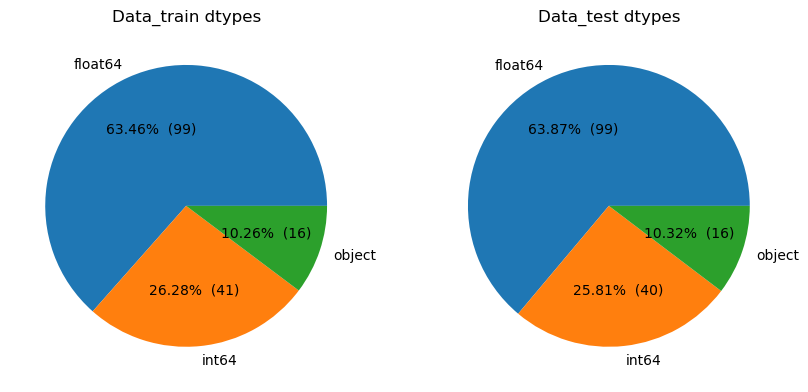

In [5]:
#data cleaning
fig,ax=plt.subplots(1,2,figsize=(10,5))
counts=data_train.dtypes.value_counts()
ax[0].pie(counts.values,labels=counts.index, autopct=lambda p : '{:.2f}%  ({:,.0f})'.format(p, p*sum(counts.values)/100))
ax[0].set_title('Data_train dtypes')
counts=data_test.dtypes.value_counts()
ax[1].pie(counts.values,labels=counts.index, autopct=lambda p : '{:.2f}%  ({:,.0f})'.format(p, p*sum(counts.values)/100))
ax[1].set_title('Data_test dtypes')
plt.show()

In [6]:
int_64_col= data_train.dtypes[data_train.dtypes=='int64'].index

describe1= data_train[int_64_col].describe()

describe1.iloc[:,:20]


SK_ID_CURR         TARGET   CNT_CHILDREN     DAYS_BIRTH  \
count  307511.000000  307511.000000  307511.000000  307511.000000   
mean   278180.518577       0.080729       0.417052  -16036.995067   
std    102790.175348       0.272419       0.722121    4363.988632   
min    100002.000000       0.000000       0.000000  -25229.000000   
25%    189145.500000       0.000000       0.000000  -19682.000000   
50%    278202.000000       0.000000       0.000000  -15750.000000   
75%    367142.500000       0.000000       1.000000  -12413.000000   
max    456255.000000       1.000000      19.000000   -7489.000000   

       DAYS_EMPLOYED  DAYS_ID_PUBLISH     FLAG_MOBIL  FLAG_EMP_PHONE  \
count  307511.000000    307511.000000  307511.000000   307511.000000   
mean    63815.045904     -2994.202373       0.999997        0.819889   
std    141275.766519      1509.450419       0.001803        0.384280   
min    -17912.000000     -7197.000000       0.000000        0.000000   
25%     -2760.000000     -4299.000000       1.000000        1.000000   
50%     -1213.000000     -3254.000000       1.000000        1.000000   
75%      -289.000000     -1720.000000       1.000000        1.000000   
max    365243.000000         0.000000       1.000000        1.000000   

       FLAG_WORK_PHONE  FLAG_CONT_MOBILE     FLAG_PHONE     FLAG_EMAIL  \
count    307511.000000     307511.000000  307511.000000  307511.000000   
mean          0.199368          0.998133       0.281066       0.056720   
std           0.399526          0.043164       0.449521       0.231307   
min           0.000000          0.000000       0.000000       0.000000   
25%           0.000000          1.000000       0.000000       0.000000   
50%           0.000000          1.000000       0.000000       0.000000   
75%           0.000000          1.000000       1.000000       0.000000   
max           1.000000          1.000000       1.000000       1.000000   

       REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
count         307511.000000                307511.000000   
mean               2.052463                     2.031521   
std                0.509034                     0.502737   
min                1.000000                     1.000000   
25%                2.000000                     2.000000   
50%                2.000000                     2.000000   
75%                2.000000                     2.000000   
max                3.000000                     3.000000   

       HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
count            307511.000000               307511.000000   
mean                 12.063419                    0.015144   
std                   3.265832                    0.122126   
min                   0.000000                    0.000000   
25%                  10.000000                    0.000000   
50%                  12.000000                    0.000000   
75%                  14.000000                    0.000000   
max                  23.000000                    1.000000   

       REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
count               307511.000000                307511.000000   
mean                     0.050769                     0.040659   
std                      0.219526                     0.197499   
min                      0.000000                     0.000000   
25%                      0.000000                     0.000000   
50%                      0.000000                     0.000000   
75%                      0.000000                     0.000000   
max                      1.000000                     1.000000   

       REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  
count           307511.000000           307511.000000  
mean                 0.078173                0.230454  
std                  0.268444                0.421124  
min                  0.000000                0.000000  
25%                  0.000000                0.000000  
50%                  0.000000            

In [7]:
train_cat=list(data_train.dtypes[data_train.dtypes==object].index)
train_cat += ['TARGET', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
              'FLAG_PHONE', 'FLAG_EMAIL', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
              'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
              'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 
              'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 
              'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 
              'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16',
              'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
              'FLAG_DOCUMENT_21']

train_num = [col for col in data_train.columns if col not in train_cat]

print(f"Nombre de variables catégoriques : {len(train_cat)}")
print(f"Nombre de variables numériques : {len(train_num)}")

Nombre de variables catégoriques : 49
Nombre de variables numériques : 107


In [8]:
def features_eng(data):
    flagdoc=['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 
              'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 
              'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 
              'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16',
              'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
              'FLAG_DOCUMENT_21']
    data['NB_FLAG_DOCUMENTS']=data[flagdoc].sum(axis=1)
    data.drop(columns=flagdoc,axis=1,inplace=True)
    data['age']=data['DAYS_BIRTH']/-365
    data['periode_empl']=data['DAYS_EMPLOYED']/-365
    data['publication']=data['DAYS_ID_PUBLISH']/-365
    data['registration']=data['DAYS_REGISTRATION']/-365
    data['credit_income_ratio']=data['AMT_CREDIT']/data['AMT_INCOME_TOTAL']
    
features_eng(data_train)
features_eng(data_test)


In [9]:
print("le nombre de variables catégoriques est :'{}'".format(len(train_cat)-20))

le nombre de variables catégoriques est :'29'


In [10]:
flagdoc=['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 
              'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 
              'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 
              'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16',
              'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
              'FLAG_DOCUMENT_21']
for cat in flagdoc:
    train_cat.remove(cat)

In [11]:
train_cat

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE',
 'TARGET',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY']

In [12]:

train_num = [col for col in data_train.columns if col not in train_cat]

print(f"Nombre de variables catégoriques : {len(train_cat)}")
print(f"Nombre de variables numériques : {len(train_num)}")

Nombre de variables catégoriques : 29
Nombre de variables numériques : 113


In [13]:
columns_to_drop=['DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH']
data_train.drop(columns=columns_to_drop,inplace=True)
data_test.drop(columns=columns_to_drop,inplace=True)
train_num = [col for col in data_train.columns if col not in train_cat]

print(f"Nombre de variables catégoriques : {len(train_cat)}")
print(f"Nombre de variables numériques : {len(train_num)}")

Nombre de variables catégoriques : 29
Nombre de variables numériques : 109


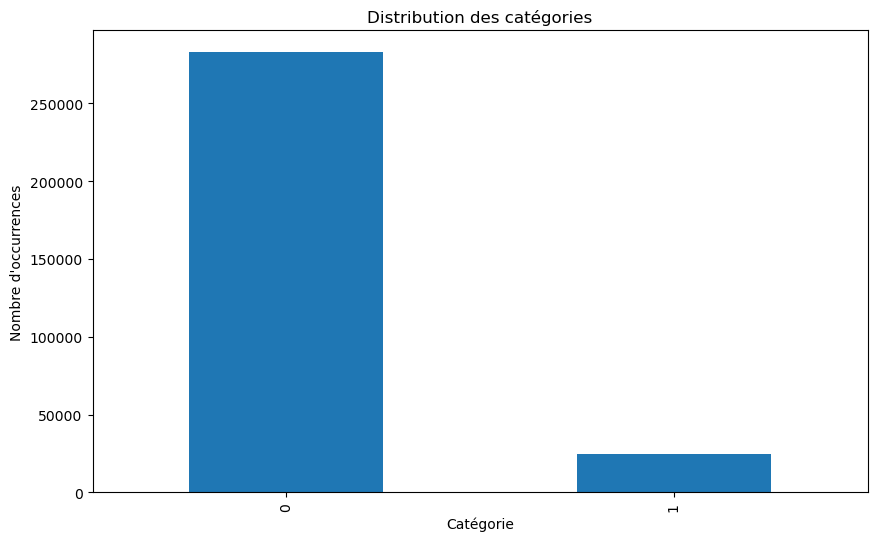

In [14]:
# Compter les occurrences de chaque catégorie
category_counts = data_train['TARGET'].value_counts()

# Créer un graphique à barres
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar')
plt.xlabel('Catégorie')
plt.ylabel('Nombre d\'occurrences')
plt.title('Distribution des catégories')
plt.show()

In [15]:
print("unbalanced data base") 

unbalanced data base


In [16]:
pd.set_option('display.max_row',None)
pd.set_option('display.max_column',None)

In [17]:
(data_train.isna().sum()/data_train.shape[0]).sort_values()

SK_ID_CURR                      0.000000
FLAG_EMAIL                      0.000000
REGION_RATING_CLIENT            0.000000
REGION_RATING_CLIENT_W_CITY     0.000000
WEEKDAY_APPR_PROCESS_START      0.000000
HOUR_APPR_PROCESS_START         0.000000
REG_REGION_NOT_LIVE_REGION      0.000000
REG_REGION_NOT_WORK_REGION      0.000000
LIVE_REGION_NOT_WORK_REGION     0.000000
REG_CITY_NOT_LIVE_CITY          0.000000
REG_CITY_NOT_WORK_CITY          0.000000
LIVE_CITY_NOT_WORK_CITY         0.000000
ORGANIZATION_TYPE               0.000000
registration                    0.000000
NB_FLAG_DOCUMENTS               0.000000
age                             0.000000
periode_empl                    0.000000
publication                     0.000000
FLAG_PHONE                      0.000000
FLAG_CONT_MOBILE                0.000000
credit_income_ratio             0.000000
FLAG_EMP_PHONE                  0.000000
NAME_CONTRACT_TYPE              0.000000
CNT_CHILDREN                    0.000000
AMT_INCOME_TOTAL

In [18]:
(data_test.isna().sum()/data_test.shape[0]).sort_values()

SK_ID_CURR                      0.000000
CNT_FAM_MEMBERS                 0.000000
REGION_RATING_CLIENT            0.000000
REGION_RATING_CLIENT_W_CITY     0.000000
WEEKDAY_APPR_PROCESS_START      0.000000
HOUR_APPR_PROCESS_START         0.000000
REG_REGION_NOT_LIVE_REGION      0.000000
REG_REGION_NOT_WORK_REGION      0.000000
LIVE_REGION_NOT_WORK_REGION     0.000000
FLAG_EMAIL                      0.000000
REG_CITY_NOT_LIVE_CITY          0.000000
LIVE_CITY_NOT_WORK_CITY         0.000000
ORGANIZATION_TYPE               0.000000
registration                    0.000000
DAYS_LAST_PHONE_CHANGE          0.000000
NB_FLAG_DOCUMENTS               0.000000
age                             0.000000
periode_empl                    0.000000
publication                     0.000000
REG_CITY_NOT_WORK_CITY          0.000000
FLAG_PHONE                      0.000000
credit_income_ratio             0.000000
FLAG_WORK_PHONE                 0.000000
CNT_CHILDREN                    0.000000
FLAG_CONT_MOBILE

In [19]:
def missing_values(data):
    shape_init=data.shape[1]
    for col in data.columns:
        if round(data[col].isna().sum()/data.shape[0]*100, 2) > 60:
            data.drop(columns=[col], inplace=True)
            if col in train_num:
                train_num.remove(col)
            elif col in train_cat:
                train_cat.remove(col)
    print(f"Nombre de variables supprimées : {shape_init-data.shape[1]}")
    print(f"Variables catégoriques restantes : {len(train_cat)}")     
    print(f"Variables numériques restantes : {len(train_num)}")
#visualisation of recently updated datasets
missing_values(data_train)
missing_values(data_test)


Nombre de variables supprimées : 24
Variables catégoriques restantes : 28
Variables numériques restantes : 86
Nombre de variables supprimées : 24
Variables catégoriques restantes : 28
Variables numériques restantes : 86


Nombre de variables avec des valeurs manquantes : 77


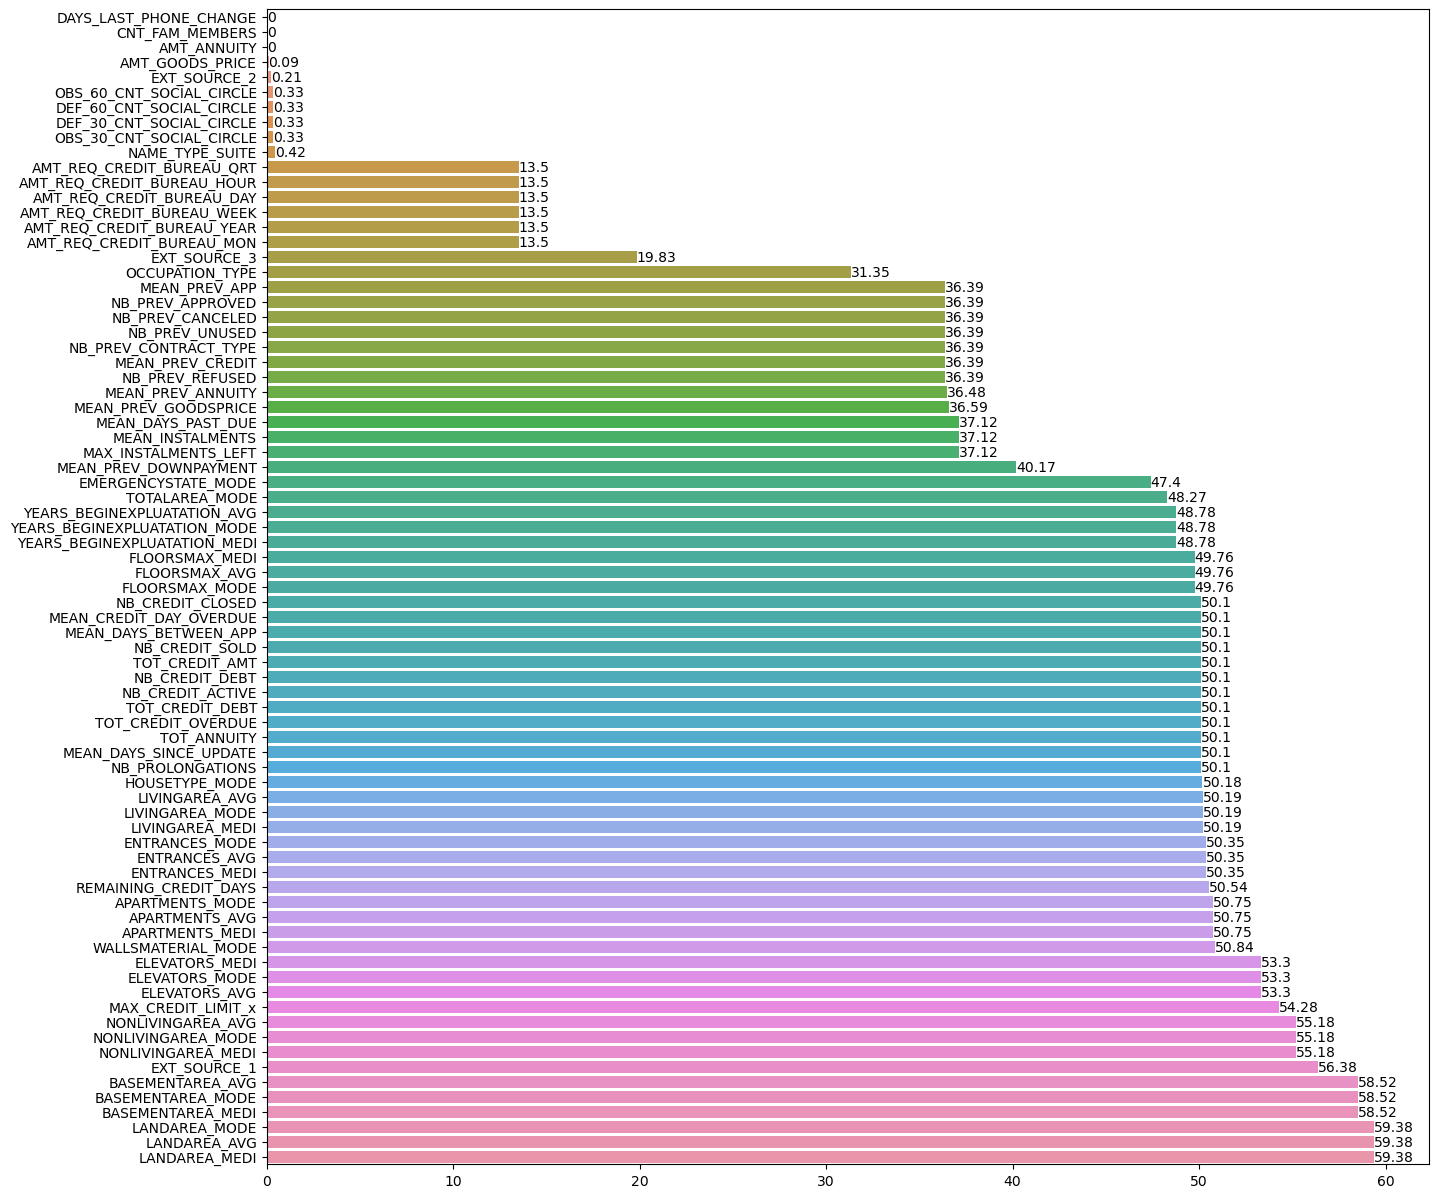

In [20]:
plt.figure(figsize=(15, 15))
counts = pd.Series(data_train.isna().sum()).loc[data_train.isna().sum()>0].sort_values()
print(f"Nombre de variables avec des valeurs manquantes : {counts.shape[0]}")
ax = sns.barplot(x=np.round(counts.values/data_train.shape[0]*100, 2), y=counts.index)
# Plot with % labels
for i in ax.containers:
    plt.bar_label(i, )
    plt.show()

Nombre de variables avec des valeurs manquantes : 74


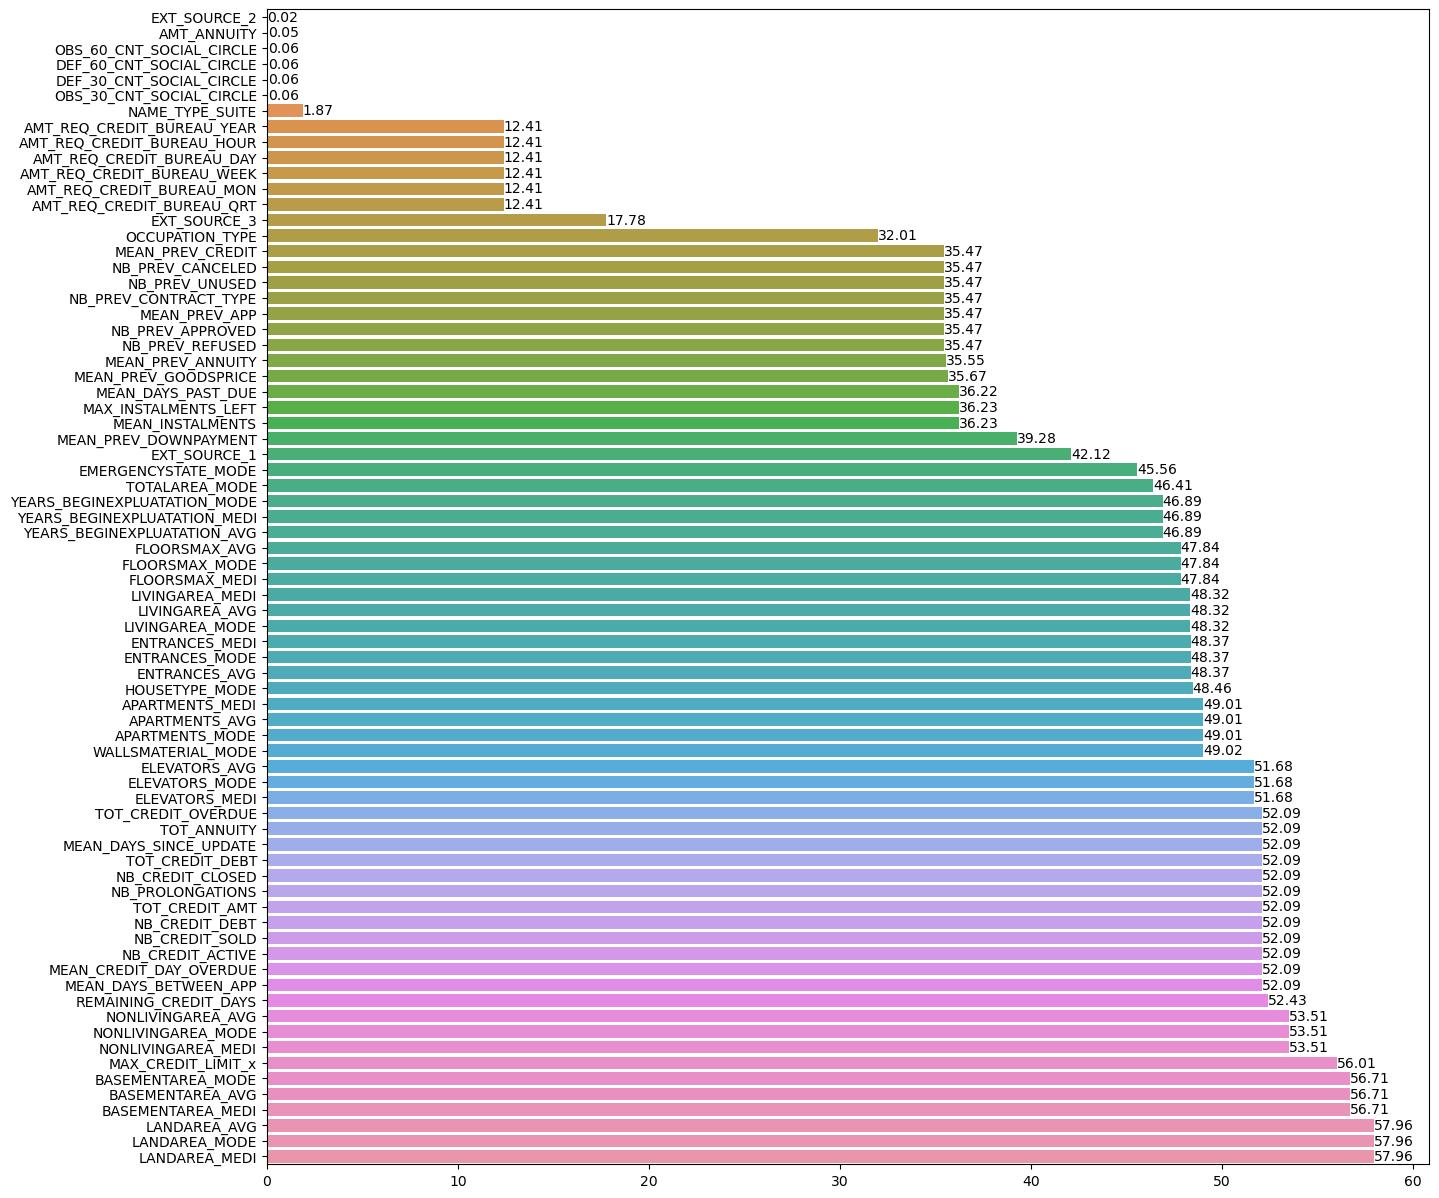

In [21]:
plt.figure(figsize=(15, 15))
counts = pd.Series(data_test.isna().sum()).loc[data_test.isna().sum()>0].sort_values()
print(f"Nombre de variables avec des valeurs manquantes : {counts.shape[0]}")
ax = sns.barplot(x=np.round(counts.values/data_test.shape[0]*100, 2), y=counts.index)
# Plot with % labels
for i in ax.containers:
    plt.bar_label(i, )
    plt.show()

In [22]:
(data_test.isna().sum()/data_test.shape[0]).sort_values()

SK_ID_CURR                      0.000000
REGION_RATING_CLIENT            0.000000
REGION_RATING_CLIENT_W_CITY     0.000000
WEEKDAY_APPR_PROCESS_START      0.000000
HOUR_APPR_PROCESS_START         0.000000
REG_REGION_NOT_LIVE_REGION      0.000000
REG_REGION_NOT_WORK_REGION      0.000000
LIVE_REGION_NOT_WORK_REGION     0.000000
REG_CITY_NOT_LIVE_CITY          0.000000
REG_CITY_NOT_WORK_CITY          0.000000
LIVE_CITY_NOT_WORK_CITY         0.000000
ORGANIZATION_TYPE               0.000000
registration                    0.000000
DAYS_LAST_PHONE_CHANGE          0.000000
NB_FLAG_DOCUMENTS               0.000000
age                             0.000000
periode_empl                    0.000000
publication                     0.000000
CNT_FAM_MEMBERS                 0.000000
FLAG_EMAIL                      0.000000
credit_income_ratio             0.000000
FLAG_CONT_MOBILE                0.000000
FLAG_OWN_CAR                    0.000000
CODE_GENDER                     0.000000
NAME_CONTRACT_TY

In [23]:
(data_train.isna().sum()/data_train.shape[0]).sort_values()

SK_ID_CURR                      0.000000
FLAG_EMAIL                      0.000000
REGION_RATING_CLIENT            0.000000
REGION_RATING_CLIENT_W_CITY     0.000000
WEEKDAY_APPR_PROCESS_START      0.000000
HOUR_APPR_PROCESS_START         0.000000
REG_REGION_NOT_LIVE_REGION      0.000000
REG_REGION_NOT_WORK_REGION      0.000000
LIVE_REGION_NOT_WORK_REGION     0.000000
REG_CITY_NOT_LIVE_CITY          0.000000
REG_CITY_NOT_WORK_CITY          0.000000
LIVE_CITY_NOT_WORK_CITY         0.000000
ORGANIZATION_TYPE               0.000000
registration                    0.000000
NB_FLAG_DOCUMENTS               0.000000
age                             0.000000
periode_empl                    0.000000
publication                     0.000000
FLAG_PHONE                      0.000000
FLAG_CONT_MOBILE                0.000000
credit_income_ratio             0.000000
FLAG_EMP_PHONE                  0.000000
CODE_GENDER                     0.000000
NAME_CONTRACT_TYPE              0.000000
TARGET          

In [24]:
data_train=data_train.drop('SK_ID_CURR',axis=1)
data_test=data_test.drop('SK_ID_CURR',axis=1)

In [25]:
from sklearn.impute import SimpleImputer
#strategy mean for floats
imputer=SimpleImputer(missing_values=np.nan,strategy='mean')
float_64=list(data_train.dtypes[data_train.dtypes=='float64'].index)
data_train[float_64]=imputer.fit_transform(data_train[float_64])
float_64=list(data_test.dtypes[data_test.dtypes=='float64'].index)
data_test[float_64]=imputer.fit_transform(data_test[float_64])
#strategy median for ints
data=data_train.drop('TARGET',axis=1)
imputer=SimpleImputer(missing_values=np.nan,strategy='median')
int_64=list(data.dtypes[data.dtypes=='int64'].index)
data_train[int_64]=imputer.fit_transform(data[int_64])
int_64=list(data_test.dtypes[data_test.dtypes=='int64'].index)
data_test[int_64]=imputer.fit_transform(data_test[int_64])


In [26]:
missing_values(data_train)

Nombre de variables supprimées : 0
Variables catégoriques restantes : 28
Variables numériques restantes : 86


Nombre de variables avec des valeurs manquantes : 5


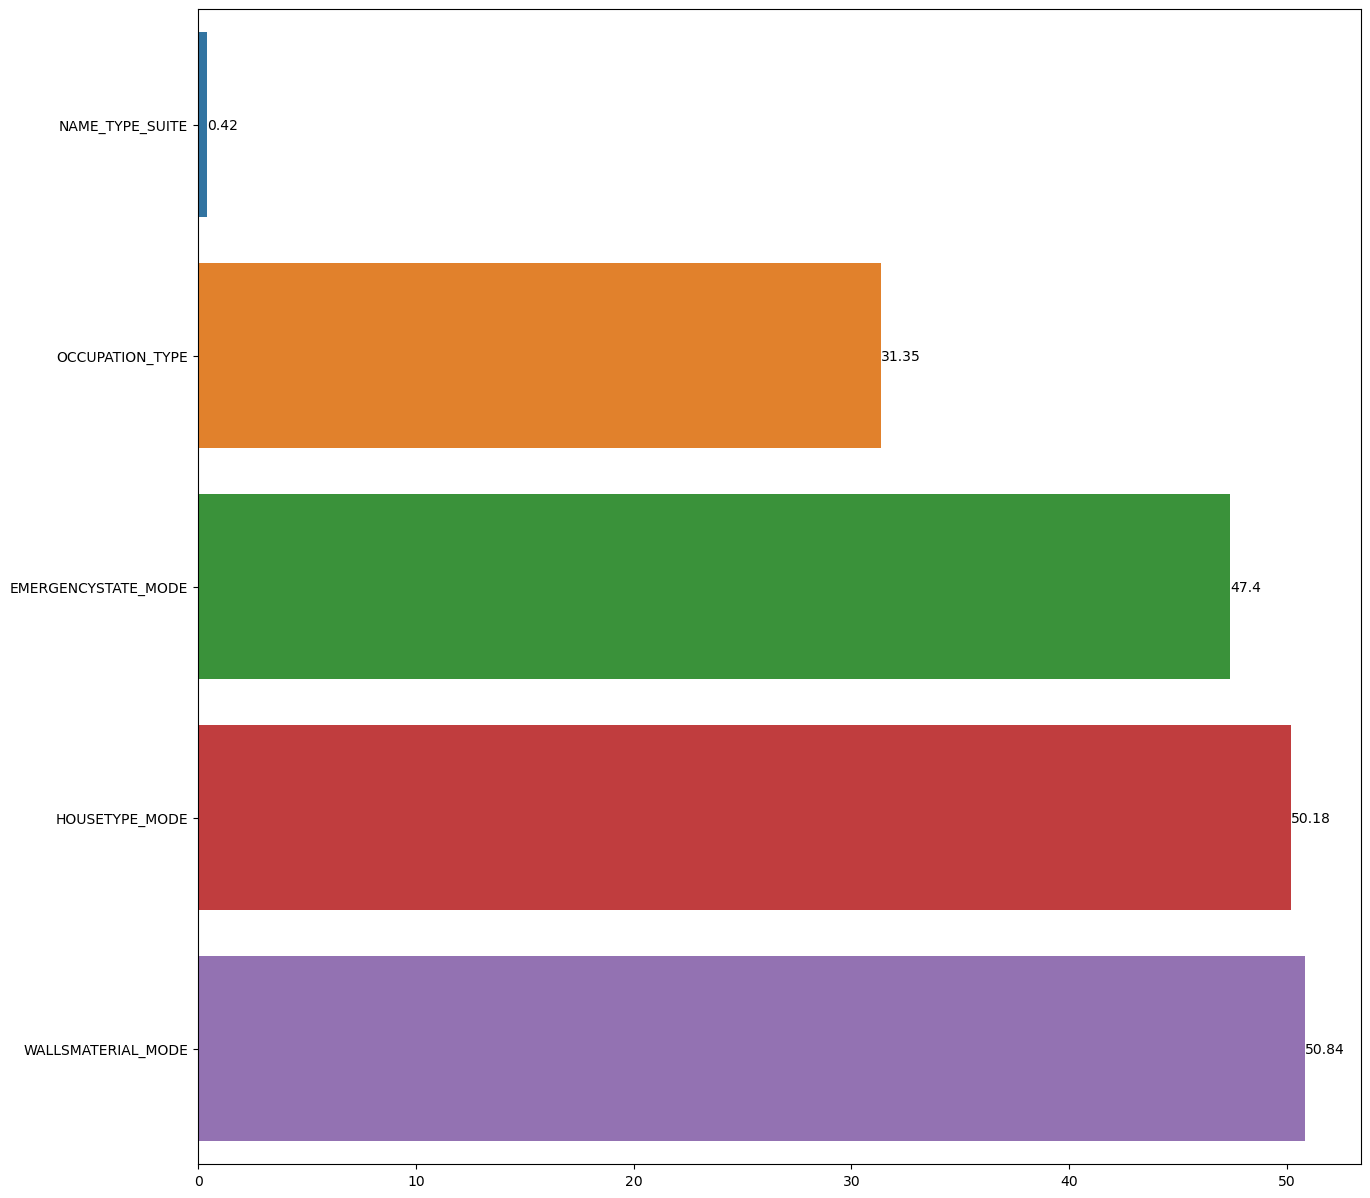

In [27]:
plt.figure(figsize=(15, 15))
counts = pd.Series(data_train.isna().sum()).loc[data_train.isna().sum()>0].sort_values()
print(f"Nombre de variables avec des valeurs manquantes : {counts.shape[0]}")
ax = sns.barplot(x=np.round(counts.values/data_train.shape[0]*100, 2), y=counts.index)
# Plot with % labels
for i in ax.containers:
    plt.bar_label(i, )
    plt.show()

In [28]:
missing_values(data_test)

Nombre de variables supprimées : 0
Variables catégoriques restantes : 28
Variables numériques restantes : 86


Nombre de variables avec des valeurs manquantes : 5


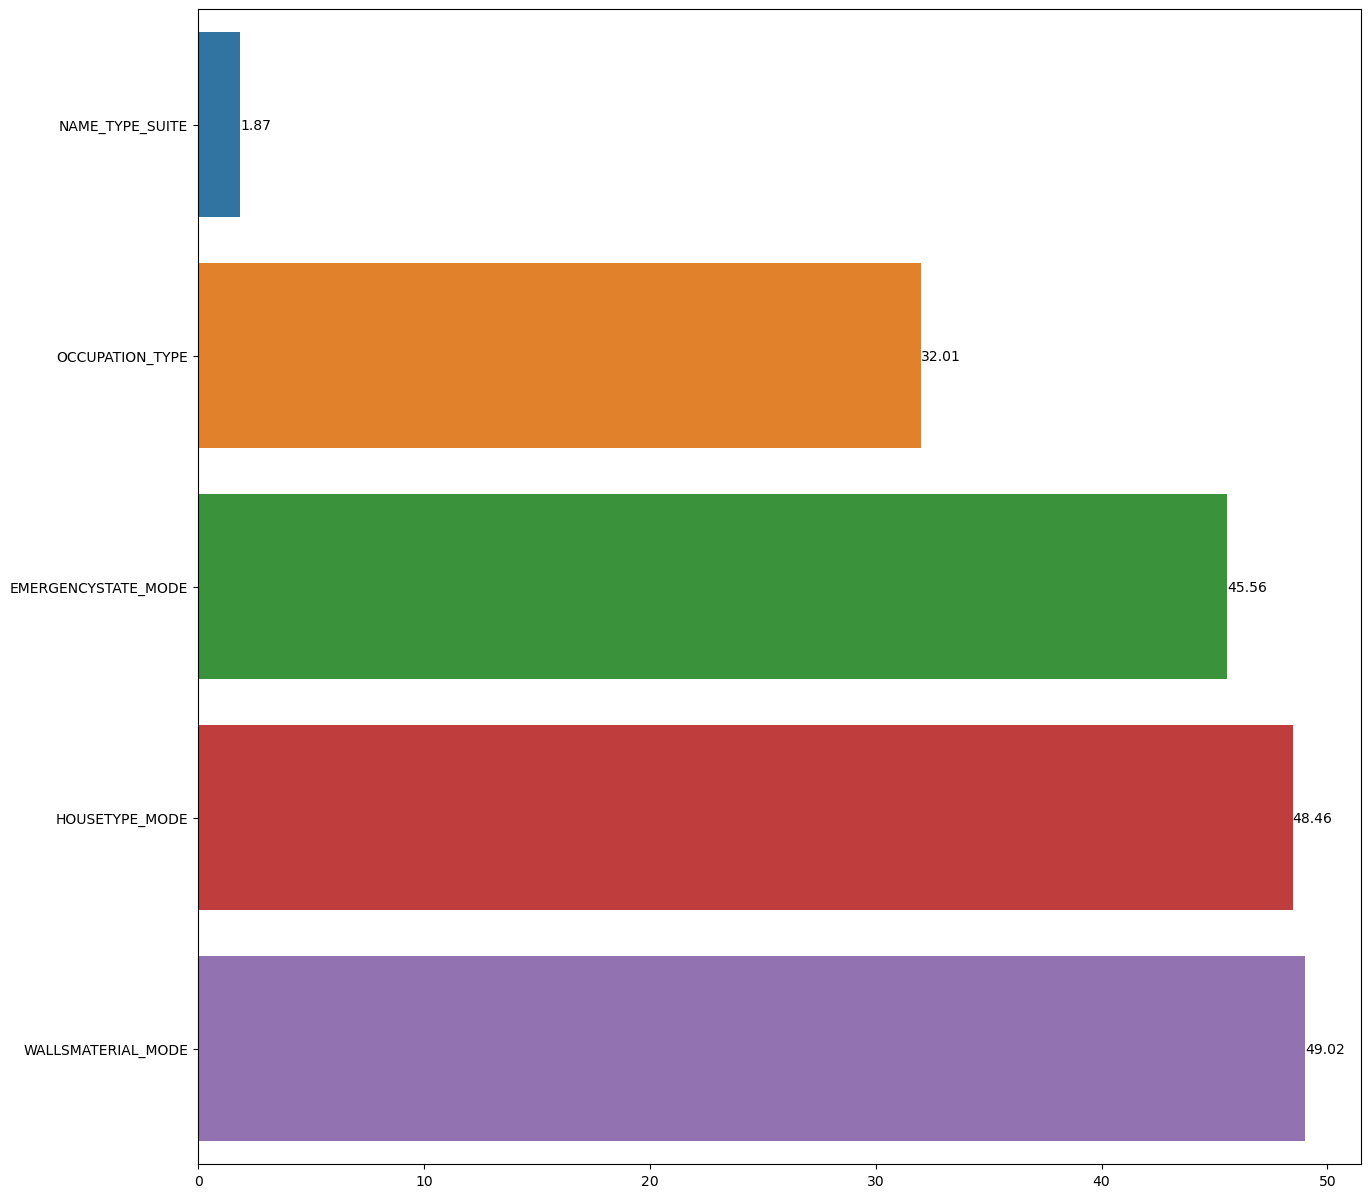

In [29]:
plt.figure(figsize=(15, 15))
counts = pd.Series(data_test.isna().sum()).loc[data_test.isna().sum()>0].sort_values()
print(f"Nombre de variables avec des valeurs manquantes : {counts.shape[0]}")
ax = sns.barplot(x=np.round(counts.values/data_test.shape[0]*100, 2), y=counts.index)
# Plot with % labels
for i in ax.containers:
    plt.bar_label(i, )
    plt.show()

In [30]:
missing_values1 = list(data_train.columns[data_train.isna().sum()>0])
missing_values2 = list(data_test.columns[data_test.isna().sum()>0])
print("les colonnes avec des valeurs manquentes de data_train:'{}'".format(missing_values1))
print("les colonnes avec des valeurs manquentes de data_test:'{}'".format(missing_values2))


les colonnes avec des valeurs manquentes de data_train:'['NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']'
les colonnes avec des valeurs manquentes de data_test:'['NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']'


In [31]:
missing_values1

['NAME_TYPE_SUITE',
 'OCCUPATION_TYPE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

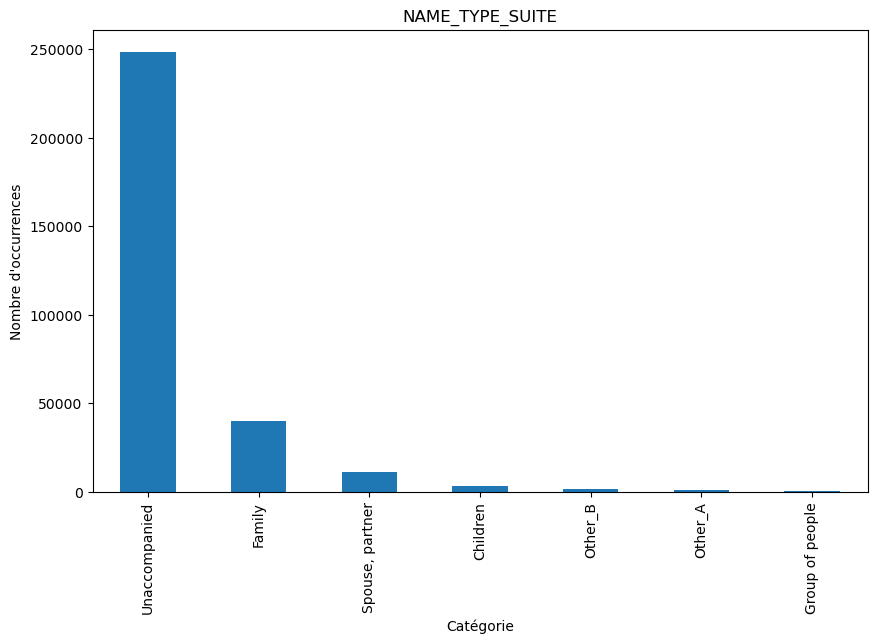

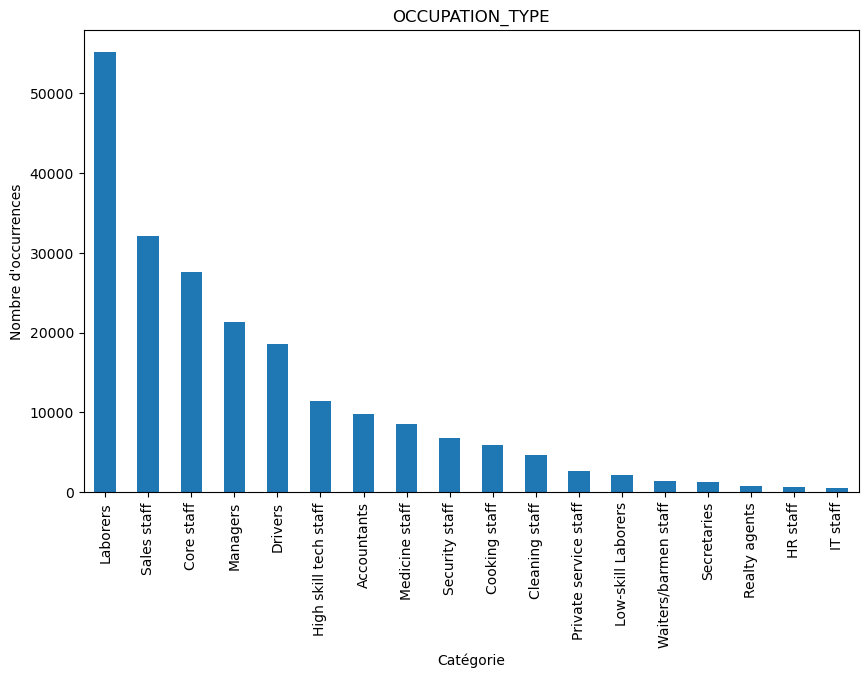

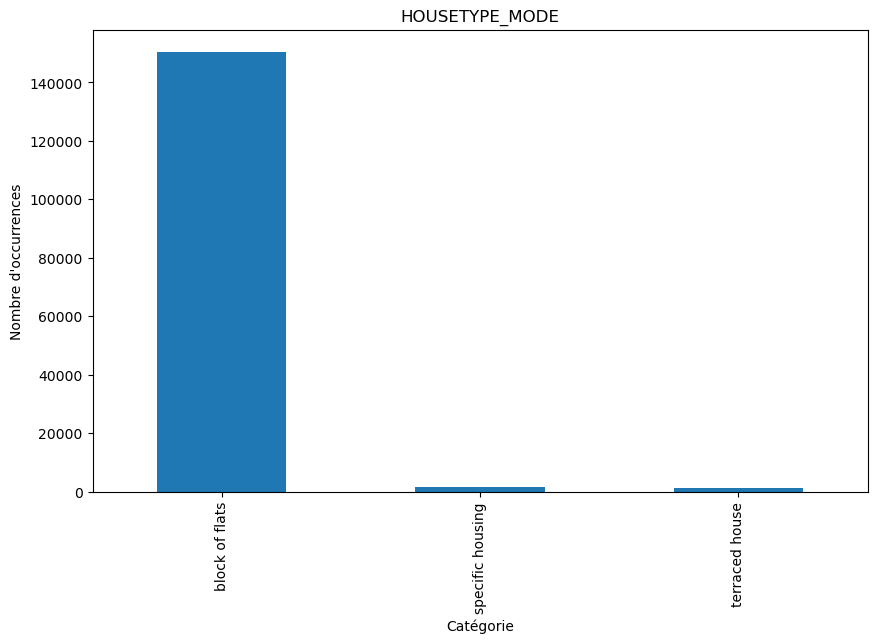

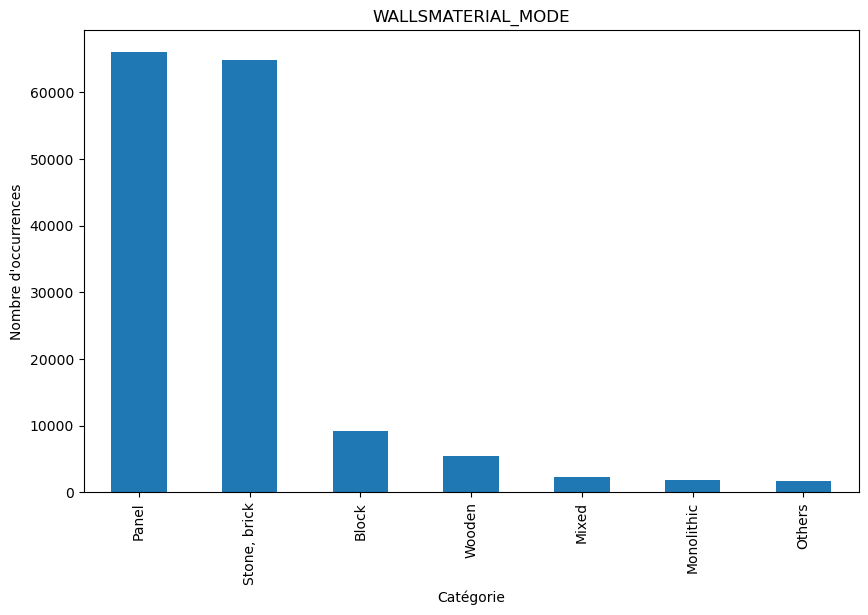

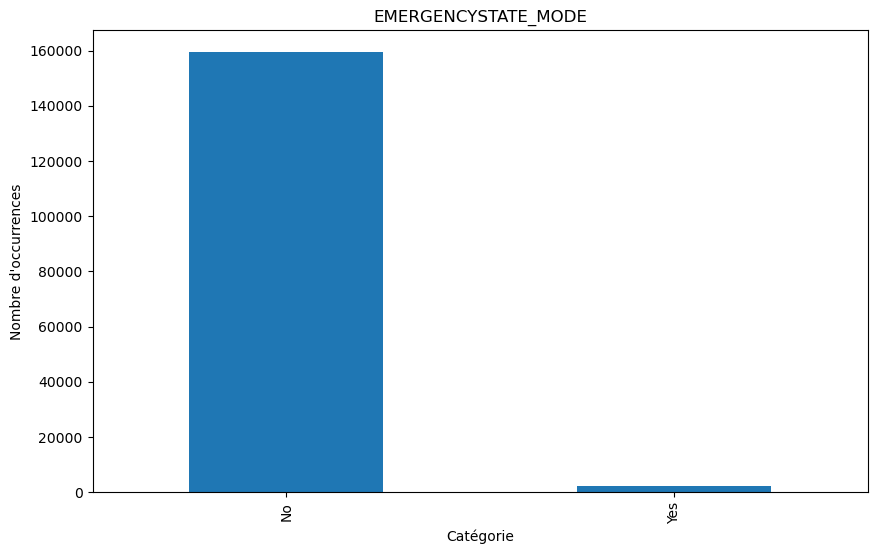

In [32]:
for col in missing_values1:
    plt.figure(figsize=(10,6))
    counts=data_train[col].value_counts()
    counts.plot(kind='bar')
    plt.xlabel('Catégorie')
    plt.ylabel('Nombre d\'occurrences')
    plt.title(col)
    plt.show()

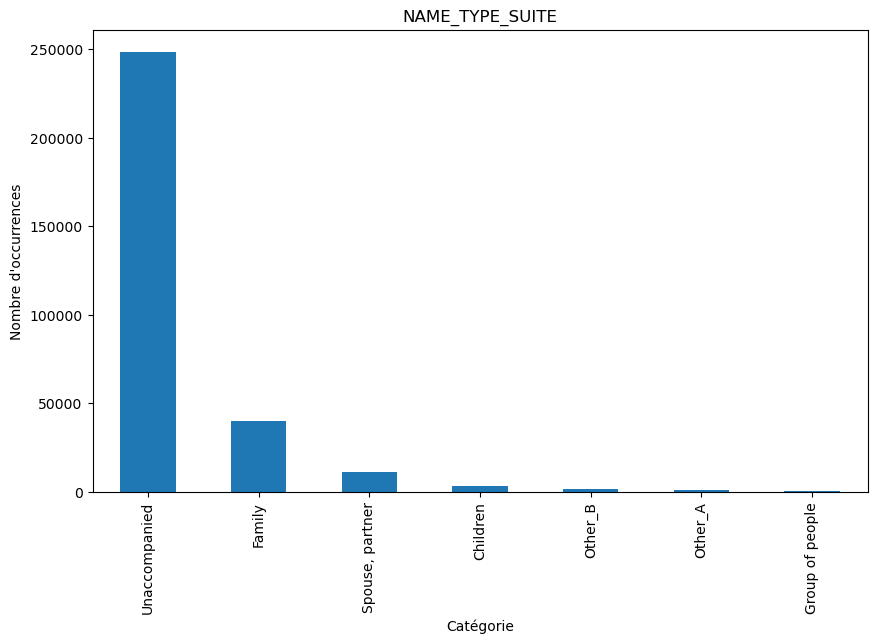

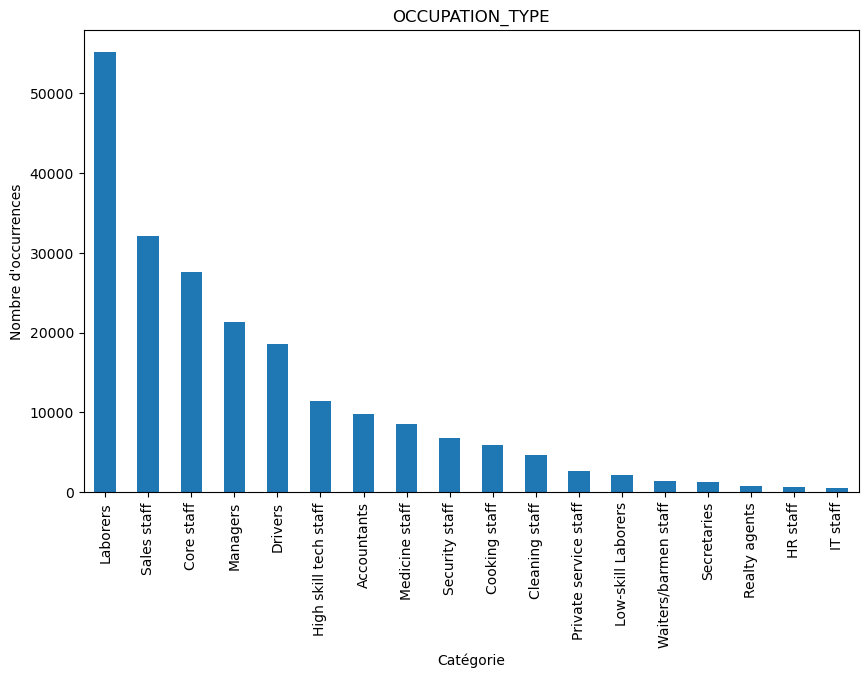

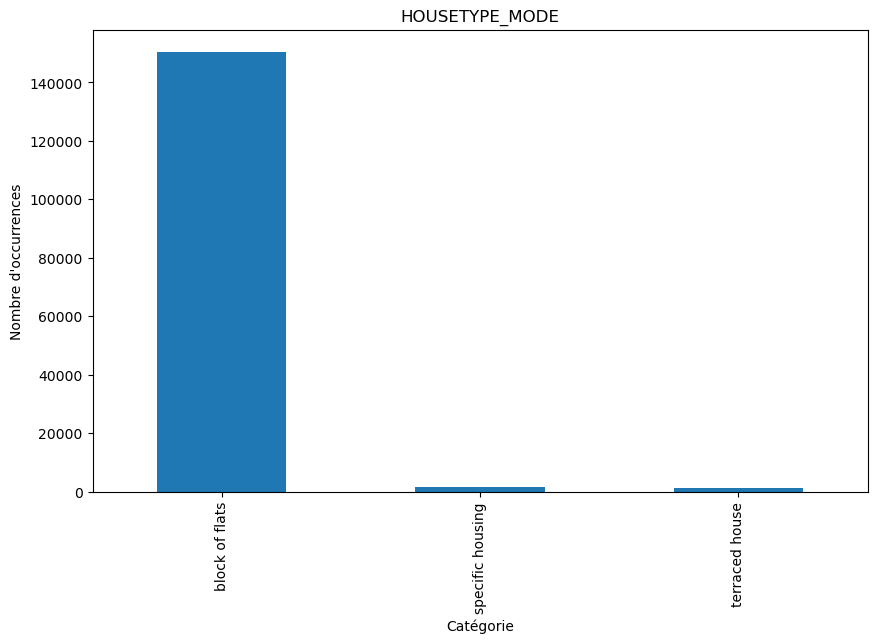

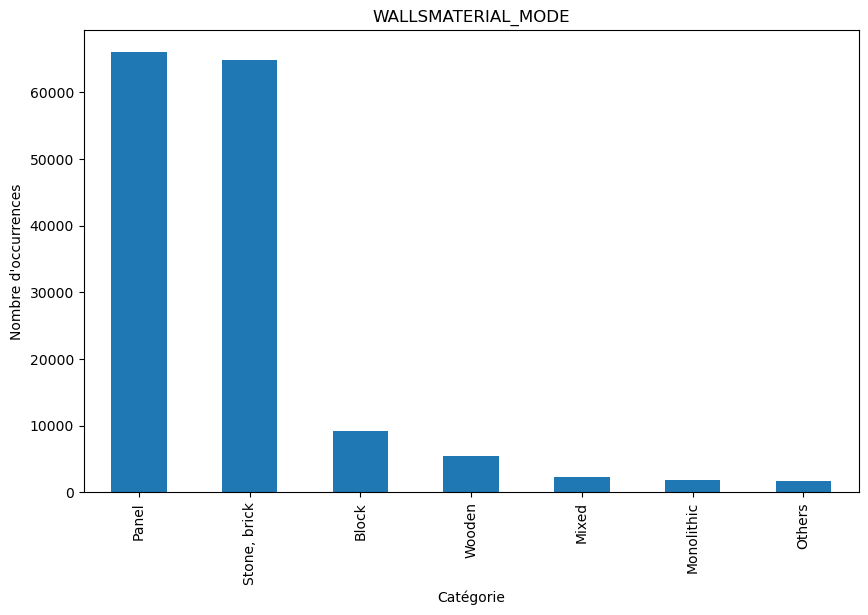

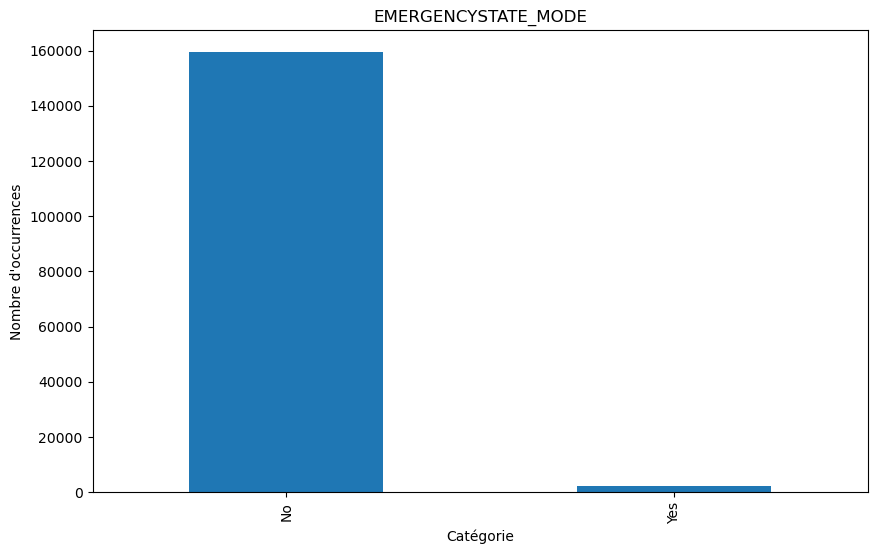

In [33]:
for col in missing_values2:
    plt.figure(figsize=(10,6))
    counts=data_train[col].value_counts()
    counts.plot(kind='bar')
    plt.xlabel('Catégorie')
    plt.ylabel('Nombre d\'occurrences')
    plt.title(col)
    plt.show()

In [34]:
def fillna_cat(data):
    # np.NaN dans NAME_TYPE_SUITE = pas d'accompagnateur
    data['NAME_TYPE_SUITE'].fillna('Unaccompanied', inplace=True)
    # np.NaN dans OCCUPATION_TYPE = autre occupation OU pas d'occupation
    data['OCCUPATION_TYPE'].fillna('Other/No occupation', inplace=True)
    # EMERGENCYSTATE_MODE : 'Yes' ou 'No' : Remplacer par le plus fréquent
    data['EMERGENCYSTATE_MODE'].fillna(data['EMERGENCYSTATE_MODE'].value_counts().index[0], inplace=True)
    # np.NaN dans HOUSETYPE_MODE = autre type de logement OU pas de logement
    data['HOUSETYPE_MODE'].fillna('Other/No housetype', inplace=True)
    # np.NaN dans WALLSMATERIAL_MODE = autre type de matériaux : catégorie existante
    data['WALLSMATERIAL_MODE'].fillna('Others', inplace=True)


In [35]:

fillna_cat(data_train)
fillna_cat(data_test)

print("Nombre de valeurs manquantes")
print(f"- dans data_train : {data_train.isna().sum().sum()}")
print(f"- dans data_test : {data_test.isna().sum().sum()}")

Nombre de valeurs manquantes
- dans data_train : 0
- dans data_test : 0


In [36]:
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
data_train=data_train.loc[data_train.CODE_GENDER!='XNA',:]
def encoding(data):
    original_columns = list(data.columns)
    inf2 = [cat for cat in data.dtypes[data.dtypes==object].index if data[cat].nunique() <= 2]
    sup2 = [cat for cat in data.dtypes[data.dtypes==object].index if data[cat].nunique() > 2]
    
    for cat in inf2:
        data[cat] = label_encoder.fit_transform(data[cat])
        
    data = pd.get_dummies(data, columns= sup2)
        
    new_columns = [c for c in data.columns if c not in original_columns]
    return data, new_columns

data_train, new_columns_tr = encoding(data_train)
data_test, new_columns_te = encoding(data_test)

print(f"Nombre de colonnes ajoutées à data_train : {len(new_columns_tr)}")
print(f"Dimensions data_train : {data_train.shape}")
print(f"Nombre de colonnes ajoutées à data_test : {len(new_columns_te)}")
print(f"Dimensions data_test : {data_test.shape}")

Nombre de colonnes ajoutées à data_train : 127
Dimensions data_train : (307507, 230)
Nombre de colonnes ajoutées à data_test : 125
Dimensions data_test : (48744, 227)


In [37]:
data_train['TARGET'].isna().sum()

0

In [38]:
print("as we visualized earlier, our data frame is unbalanced .To balance it,we can over sample it or under sample it; Our choice of strategy will be taken by trying both strategies on our data set and choosing the best behaviour .")

as we visualized earlier, our data frame is unbalanced .To balance it,we can over sample it or under sample it; Our choice of strategy will be taken by trying both strategies on our data set and choosing the best behaviour .


In [39]:
print("Variables présentes dans le dataset d'entraînement et non dans le dataset de test :")
print()

var_to_pop = [var for var in data_train.columns if var not in data_test.columns]
data_train.drop(columns=var_to_pop[1:], inplace=True)

print(var_to_pop)
print(f"Dimensions data_train : {data_train.shape}")
print(f"Dimensions data_test : {data_test.shape}")

Variables présentes dans le dataset d'entraînement et non dans le dataset de test :

['TARGET', 'NAME_INCOME_TYPE_Maternity leave', 'NAME_FAMILY_STATUS_Unknown']
Dimensions data_train : (307507, 228)
Dimensions data_test : (48744, 227)


In [40]:
pearson = data_train[['TARGET'] + [col for col in data_train.columns if col != 'TARGET']].corr()

pearson.style.format("{:.1}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

In [41]:
print("the features EXT_SOURCE_1,EXT_SOURCE_2 and EXT_SOURCE_3 are the only features with an absolute corrolation coef over 0.1 with the target, that shows no data leakage and the target is not that influenced with the training features ")

the features EXT_SOURCE_1,EXT_SOURCE_2 and EXT_SOURCE_3 are the only features with an absolute corrolation coef over 0.1 with the target, that shows no data leakage and the target is not that influenced with the training features 


In [42]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

# Metrics adaptés au problème de déséquilibre des coûts
from sklearn.metrics import confusion_matrix, roc_auc_score, fbeta_score, recall_score, precision_score

#Modèles
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression#It models the probability that a given input belongs to a particular class.linear
from sklearn.ensemble import RandomForestClassifier# based on decision trees.

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

#import shap
from collections import Counter
from imblearn.over_sampling import SMOTE

In [43]:
X = data_train.drop(columns=['TARGET']).copy()
y = data_train['TARGET'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [44]:
oversampler = SMOTE()
X_train_over, y_train_over = oversampler.fit_resample(X_train,y_train)


In [45]:
print('y_train', Counter(y_train_over))
print('y_val', Counter(y_test))

y_train Counter({0: 226145, 1: 226145})
y_val Counter({0: 56537, 1: 4965})


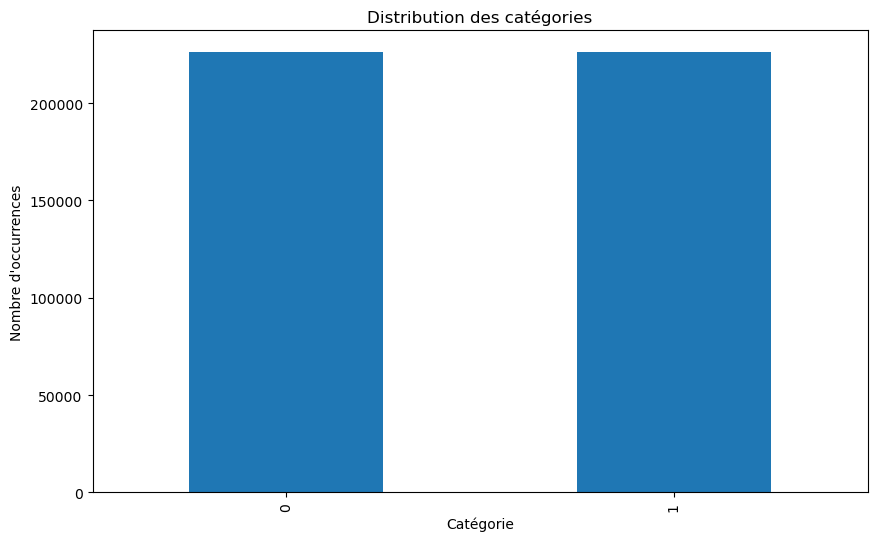

In [46]:
# Compter les occurrences de chaque catégorie
category_counts = y_train_over.value_counts()

# Créer un graphique à barres
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar')
plt.xlabel('Catégorie')
plt.ylabel('Nombre d\'occurrences')
plt.title('Distribution des catégories')
plt.show()

In [47]:
X_train_over.shape

(452290, 227)

In [48]:
y_train_over.shape

(452290,)

In [49]:
from sklearn.metrics import precision_score, recall_score, fbeta_score, roc_auc_score,accuracy_score,confusion_matrix

comp = pd.DataFrame(index = ['precision', 'recall', 'Score métier', 'AUC','accuracy'])

def score_métier(model, model_str):
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Seuil optimisé pour favoriser les prédictions positives qui ont un moindre coût 
    scores = [fbeta_score(y_test, pd.Series(y_proba).apply(lambda x: 1 if x > seuil else 0),
                          beta=2) for seuil in np.linspace(0.1, 0.9, 17)]
    seuil_opt = np.linspace(0.1, 0.9, 17)[scores.index(np.max(scores))]
    y_pred = pd.Series(y_proba).apply(lambda x: 1 if x > seuil_opt else 0)
    print(f"Seuil optimal = {seuil_opt}")
    
    conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                            columns = ['pred_0', 'pred_1'],
                            index = ['true_0', 'true_1'])
     
    precision = round(precision_score(y_test, y_pred), 3)
    recall = round(recall_score(y_test, y_pred), 3)# Recall => priorité sur précision
    fbeta = round(fbeta_score(y_test, y_pred, beta=10), 3)# Coût FN = 10 * Coût FP
    auc = round(roc_auc_score(y_test, y_proba), 3)
    accuracy=round(accuracy_score(y_test,y_pred),3)
    
    
    print(f"Precision score       : {precision}")
    print(f"Recall score          : {recall}")
    print(f"FBêta score           : {fbeta}")
    print(f"ROC AUC score         : {auc}")
    print(f"accuracy score  : {accuracy}")
    print(conf_mat)
   
    
    comp[model_str] = [precision, recall, fbeta, auc,accuracy]
    
    return conf_mat

In [50]:
cat = [col for col in data_train.columns if np.max(data_train[col])==1]
num = [col for col in data_train.columns if col not in cat]


In [51]:
from sklearn.compose import make_column_transformer
scaler = make_column_transformer((RobustScaler(), num), remainder='passthrough')
X_train_over = scaler.fit_transform(X_train_over)
X_test = scaler.transform(X_test)
model1=SGDClassifier(loss='log')
model1.fit(X_train_over,y_train_over)
score_métier(model1,'sgdclassifier')
model1.score(X_test,y_test)

Seuil optimal = 0.1
Precision score       : 0.124
Recall score          : 0.352
FBêta score           : 0.345
ROC AUC score         : 0.618
accuracy score  : 0.747
        pred_0  pred_1
true_0   44179   12358
true_1    3219    1746


0.8774511398003317

In [52]:
model2=DummyClassifier()
model2.fit(X_train_over,y_train_over)
score_métier(model2,'dummy')
model2.score(X_test,y_test)

Seuil optimal = 0.1
Precision score       : 0.081
Recall score          : 1.0
FBêta score           : 0.899
ROC AUC score         : 0.5
accuracy score  : 0.081
        pred_0  pred_1
true_0       0   56537
true_1       0    4965


0.9192709180189262

In [53]:
model3=LogisticRegression(max_iter=1000)
model3.fit(X_train_over,y_train_over)
score_métier(model3,'logistic')
model3.score(X_test,y_test)

C:\Users\MSI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Seuil optimal = 0.1
Precision score       : 0.177
Recall score          : 0.601
FBêta score           : 0.587
ROC AUC score         : 0.741
accuracy score  : 0.741
        pred_0  pred_1
true_0   42612   13925
true_1    1979    2986


0.9187993886377679

In [54]:
model4=RandomForestClassifier(n_jobs=-1)
model4.fit(X_train_over,y_train_over)
score_métier(model4,'randomforest')
model4.score(X_test,y_test)

Seuil optimal = 0.1
Precision score       : 0.117
Recall score          : 0.749
FBêta score           : 0.711
ROC AUC score         : 0.683
accuracy score  : 0.523
        pred_0  pred_1
true_0   28464   28073
true_1    1246    3719


0.9192383987512601

In [55]:
from sklearn.tree import DecisionTreeClassifier
model5=DecisionTreeClassifier(max_depth=4)
model5.fit(X_train_over,y_train_over)
score_métier(model5,'decisiontree')
model5.score(X_test,y_test)

Seuil optimal = 0.25
Precision score       : 0.112
Recall score          : 0.666
FBêta score           : 0.635
ROC AUC score         : 0.627
accuracy score  : 0.545
        pred_0  pred_1
true_0   30222   26315
true_1    1658    3307


0.7767552274722773

In [56]:
from xgboost import XGBClassifier

xgbc = XGBClassifier()
xgbc.fit(X_train_over, y_train_over)

score_métier(xgbc, 'XGradient Boosting')
xgbc.score(X_test,y_test)

Seuil optimal = 0.1
Precision score       : 0.181
Recall score          : 0.587
FBêta score           : 0.574
ROC AUC score         : 0.747
accuracy score  : 0.752
        pred_0  pred_1
true_0   43330   13207
true_1    2053    2912


0.9181977821859452

In [57]:
from lightgbm import LGBMClassifier


lgbm = LGBMClassifier()
lgbm.fit(X_train_over, y_train_over, eval_set=[(X_train_over, y_train_over), (X_test, y_test)],
         eval_metric='auc')


score_métier(lgbm, 'LGBM Classifier') 
lgbm.score(X_test, y_test)

[LightGBM] [Info] Number of positive: 226145, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.198493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24708
[LightGBM] [Info] Number of data points in the train set: 452290, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Seuil optimal = 0.1
Precision score       : 0.181
Recall score          : 0.617
FBêta score           : 0.602
ROC AUC score         : 0.755
accuracy score  : 0.745
        pred_0  pred_1
true_0   42728   13809
true_1    1903    3062


0.9193034372865923

In [58]:
print("we are certainly not considering the SGDClassifier and the DummyClassifier ")

we are certainly not considering the SGDClassifier and the DummyClassifier 


In [59]:
print("From the Logisticregression model to the randomforest , i remarked a continue decrease of FN and an increase in the recall metric ")

From the Logisticregression model to the randomforest , i remarked a continue decrease of FN and an increase in the recall metric 


In [60]:
print(" there is an increase in the FN with XGBClassifier and  LGBMClassifier ")

 there is an increase in the FN with XGBClassifier and  LGBMClassifier 


In [61]:
comp

sgdclassifier  dummy  logistic  randomforest  decisiontree  \
precision             0.124  0.081     0.177         0.117         0.112   
recall                0.352  1.000     0.601         0.749         0.666   
Score métier          0.345  0.899     0.587         0.711         0.635   
AUC                   0.618  0.500     0.741         0.683         0.627   
accuracy              0.747  0.081     0.741         0.523         0.545   

              XGradient Boosting  LGBM Classifier  
precision                  0.181            0.181  
recall                     0.587            0.617  
Score métier               0.574            0.602  
AUC                        0.747            0.755  
accuracy                   0.752            0.745

IndexError: index 2 is out of bounds for axis 0 with size 2

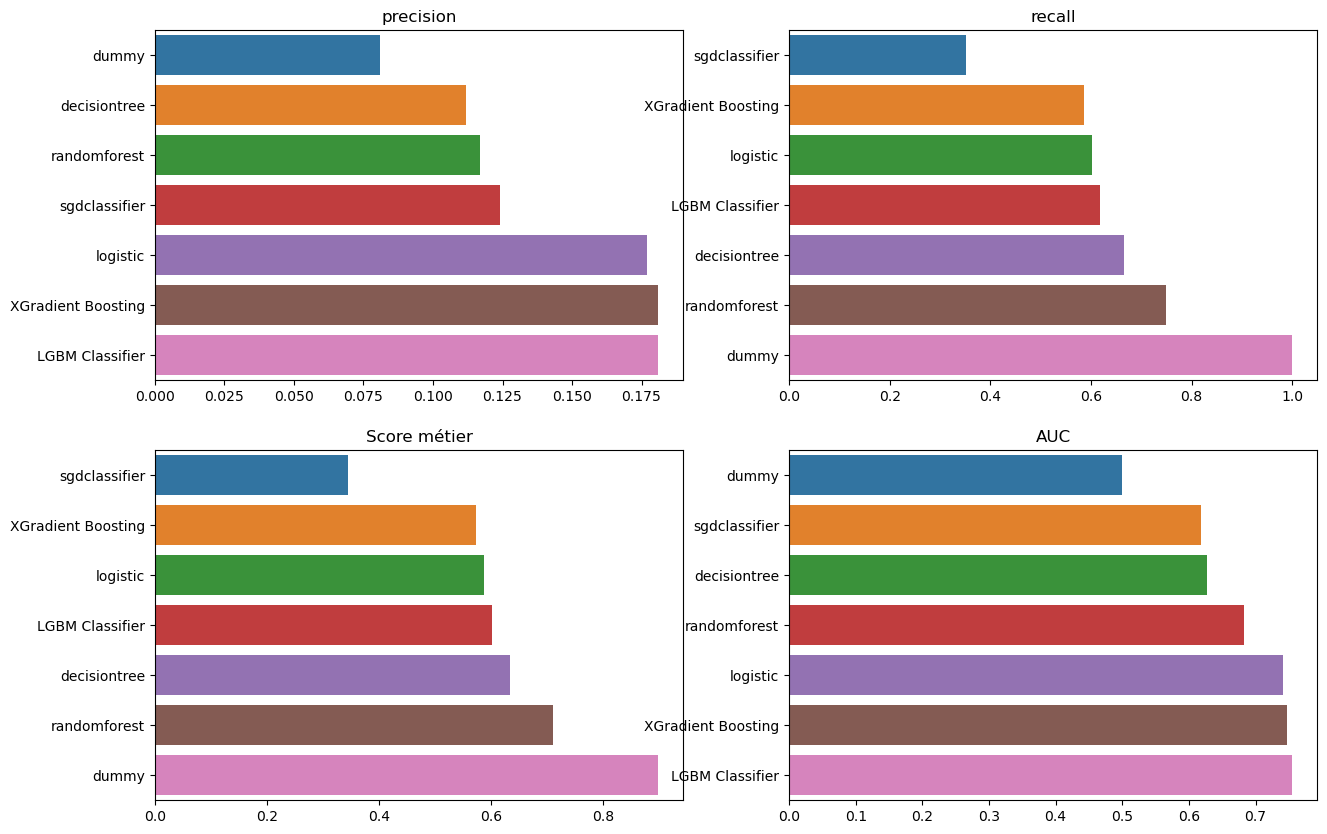

In [62]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
i=0
j=0
for index in comp.index:
    if j>1:
        i+=1
        j=0
    val = comp.loc[index, :].sort_values()
    sns.barplot(x=val.values, y=val.index, ax=ax[i, j])
    ax[i, j].set_title(f"{index}")
    j+=1

plt.show()

In [63]:
comp=comp[['randomforest','decisiontree','LGBM Classifier']]

In [64]:
comp

randomforest  decisiontree  LGBM Classifier
precision            0.117         0.112            0.181
recall               0.749         0.666            0.617
Score métier         0.711         0.635            0.602
AUC                  0.683         0.627            0.755
accuracy             0.523         0.545            0.745

In [65]:
print("now , the balancing strategy will be under sampling")

now , the balancing strategy will be under sampling


In [66]:
from imblearn.under_sampling import NearMiss
undersampler = NearMiss(sampling_strategy='auto')
X_train_under, y_train_under = undersampler.fit_resample(X_train,y_train)


In [67]:
print('y_train_under', Counter(y_train_under))
print('y_test_under', Counter(y_test))

y_train_under Counter({0: 19860, 1: 19860})
y_test_under Counter({0: 56537, 1: 4965})


In [68]:

X_test = pd.DataFrame(X_test, columns=X_train.columns)



In [69]:
X_train_under=scaler.fit_transform(X_train_under)
X_test=scaler.transform(X_test)
sgd_u=SGDClassifier(loss='log')
sgd_u.fit(X_train_under,y_train_under)
score_métier(sgd_u,'sgdclassifier under')
sgd_u.score(X_test,y_test)

Seuil optimal = 0.1
Precision score       : 0.0
Recall score          : 0.0
FBêta score           : 0.0
ROC AUC score         : 0.5
accuracy score  : 0.919
        pred_0  pred_1
true_0   56537       0
true_1    4965       0


C:\Users\MSI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MSI\AppData\Local\Temp\ipykernel_18888\2053086347.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp[model_str] = [precision, recall, fbeta, auc,accuracy]


0.9192709180189262

In [70]:
print("the goal is to satisfy 90% of accuracy and the lowest FN wish is not satisfied with SGDClassifier even if its execution time is 2min ")

the goal is to satisfy 90% of accuracy and the lowest FN wish is not satisfied with SGDClassifier even if its execution time is 2min 


In [71]:
dummy_u=DummyClassifier()
dummy_u.fit(X_train_under,y_train_under)
score_métier(dummy_u,'dummy under')
dummy_u.score(X_test,y_test)

Seuil optimal = 0.1
Precision score       : 0.081
Recall score          : 1.0
FBêta score           : 0.899
ROC AUC score         : 0.5
accuracy score  : 0.081
        pred_0  pred_1
true_0       0   56537
true_1       0    4965


C:\Users\MSI\AppData\Local\Temp\ipykernel_18888\2053086347.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp[model_str] = [precision, recall, fbeta, auc,accuracy]


0.9192709180189262

In [72]:
print("same remarque as the dummyclassifier")

same remarque as the dummyclassifier


In [73]:
lr_u=LogisticRegression(max_iter=1000)
lr_u.fit(X_train_under,y_train_under)
score_métier(lr_u,'logistic under')
lr_u.score(X_test,y_test)

Seuil optimal = 0.1
Precision score       : 0.081
Recall score          : 1.0
FBêta score           : 0.899
ROC AUC score         : 0.494
accuracy score  : 0.081
        pred_0  pred_1
true_0       0   56537
true_1       0    4965


C:\Users\MSI\AppData\Local\Temp\ipykernel_18888\2053086347.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp[model_str] = [precision, recall, fbeta, auc,accuracy]


0.9192709180189262

In [74]:
print(" same remark , we are encountering low metrics even if the score is high: all the predictions missmatch the reality")

 same remark , we are encountering low metrics even if the score is high: all the predictions missmatch the reality


In [75]:
rf_u=RandomForestClassifier(n_jobs=-1)
rf_u.fit(X_train_under,y_train_under)
score_métier(rf_u,'randomforest under')
rf_u.score(X_test,y_test)

Seuil optimal = 0.9
Precision score       : 0.081
Recall score          : 1.0
FBêta score           : 0.899
ROC AUC score         : 0.499
accuracy score  : 0.081
        pred_0  pred_1
true_0       9   56528
true_1       0    4965


0.08072908198107379

In [76]:
dc_u=DecisionTreeClassifier(max_depth=4)
dc_u.fit(X_train_under,y_train_under)
score_métier(dc_u,'decisiontree under')
dc_u.score(X_test,y_test)

Seuil optimal = 0.1
Precision score       : 0.081
Recall score          : 1.0
FBêta score           : 0.899
ROC AUC score         : 0.5
accuracy score  : 0.081
        pred_0  pred_1
true_0       0   56537
true_1       0    4965


0.08072908198107379

In [77]:

xgbc_u = XGBClassifier()
xgbc_u.fit(X_train_under, y_train_under)

score_métier(xgbc_u, 'XGradient Boosting under')
xgbc_u.score(X_test,y_test)

Seuil optimal = 0.1
Precision score       : 0.081
Recall score          : 1.0
FBêta score           : 0.899
ROC AUC score         : 0.478
accuracy score  : 0.081
        pred_0  pred_1
true_0       0   56537
true_1       0    4965


0.08072908198107379

In [78]:
lgbm_u = LGBMClassifier()
lgbm_u.fit(X_train_under, y_train_under, eval_set=[(X_train_under, y_train_under), (X_test, y_test)],
         eval_metric='auc')


score_métier(lgbm_u, 'LGBM Classifier under') 
lgbm_u.score(X_test, y_test)

[LightGBM] [Info] Number of positive: 19860, number of negative: 19860
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12727
[LightGBM] [Info] Number of data points in the train set: 39720, number of used features: 214
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Seuil optimal = 0.1
Precision score       : 0.081
Recall score          : 1.0
FBêta score           : 0.899
ROC AUC score         : 0.496
accuracy score  : 0.081
        pred_0  pred_1
true_0       0   56537
true_1       0    4965


0.08072908198107379

In [79]:
comp

randomforest  decisiontree  LGBM Classifier  \
precision            0.117         0.112            0.181   
recall               0.749         0.666            0.617   
Score métier         0.711         0.635            0.602   
AUC                  0.683         0.627            0.755   
accuracy             0.523         0.545            0.745   

              sgdclassifier under  dummy under  logistic under  \
precision                   0.000        0.081           0.081   
recall                      0.000        1.000           1.000   
Score métier                0.000        0.899           0.899   
AUC                         0.500        0.500           0.494   
accuracy                    0.919        0.081           0.081   

              randomforest under  decisiontree under  \
precision                  0.081               0.081   
recall                     1.000               1.000   
Score métier               0.899               0.899   
AUC                        0.499               0.500   
accuracy                   0.081               0.081   

              XGradient Boosting under  LGBM Classifier under  
precision                        0.081                  0.081  
recall                           1.000                  1.000  
Score métier                     0.899                  0.899  
AUC                              0.478                  0.496  
accuracy                         0.081                  0.081

In [80]:
comp=comp[['randomforest','LGBM Classifier','randomforest under','LGBM Classifier under']]

In [81]:
comp

randomforest  LGBM Classifier  randomforest under  \
precision            0.117            0.181               0.081   
recall               0.749            0.617               1.000   
Score métier         0.711            0.602               0.899   
AUC                  0.683            0.755               0.499   
accuracy             0.523            0.745               0.081   

              LGBM Classifier under  
precision                     0.081  
recall                        1.000  
Score métier                  0.899  
AUC                           0.496  
accuracy                      0.081

In [82]:
print("let's optimize the chosen models:randomforest,lgbm with oversampling ")

let's optimize the chosen models:randomforest,lgbm with oversampling 


In [84]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [85]:
param_grid ={
    'n_estimators': np.linspace(20, 200, 10).astype(int),
    'max_depth': np.linspace(2, 20, 10).astype(int),
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'n_jobs':[-1]
}

In [86]:
rs = RandomizedSearchCV(RandomForestClassifier(n_jobs=-1), 
                        param_distributions = param_grid,
                        scoring = 'recall',
                        cv = 3,
                        verbose = 3,
                        n_jobs = -1)
                        
rs.fit(X_train_over, y_train_over)
print(rs.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'n_jobs': -1, 'n_estimators': 160, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20}


In [87]:
rfc_opt=RandomForestClassifier(max_depth= 12,
 n_estimators= 50,
 n_jobs=-1)
rfc_opt.fit(X_train_over, y_train_over)
score_métier(rfc_opt,'ranfomforest opt')

Seuil optimal = 0.25
Precision score       : 0.081
Recall score          : 1.0
FBêta score           : 0.899
ROC AUC score         : 0.489
accuracy score  : 0.081
        pred_0  pred_1
true_0       1   56536
true_1       0    4965


C:\Users\MSI\AppData\Local\Temp\ipykernel_18888\2053086347.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp[model_str] = [precision, recall, fbeta, auc,accuracy]


pred_0  pred_1
true_0       1   56536
true_1       0    4965

In [88]:
rfc_opt.score(X_test,y_test)

0.3188026405645345

In [89]:
from sklearn.metrics import accuracy_score
print('Training Accuracy : ',
      accuracy_score(y_train_over, rfc_opt.predict(X_train_over))*100)
print('Validation Accuracy : ',
      accuracy_score(y_test, rfc_opt.predict(X_test))*100)
#data oversampled

Training Accuracy :  94.8404784540892
Validation Accuracy :  31.88026405645345


In [90]:
LGBMClassifier().get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [91]:
param_grid = {'uniform_drop': [True, False],
              'xgboost_dart_mode': [True, False],
              'n_estimators': np.linspace(20, 200, 10).astype(int),
              'num_leaves': [2, 20, 200],
              'min_data_in_leaf': [1, 10, 100, 1000],
              'max_depth': np.linspace(1, 10, 10).astype(int)}

In [92]:
rs = RandomizedSearchCV(LGBMClassifier(), 
                        param_distributions = param_grid,
                        scoring = 'recall',
                        cv = 3,
                        verbose = 3,
                        n_jobs = -1)
                        
rs.fit(X_train_over, y_train_over)
print(rs.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 226145, number of negative: 226145
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24692
[LightGBM] [Info] Number of data points in the train set: 452290, number of used features: 216
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

In [95]:
lgbm_opt = LGBMClassifier(xgboost_dart_mode = False, uniform_drop = False, num_leaves = 200,
                          n_estimators=160, min_data_in_leaf = 1000, max_depth = 10)
lgbm_opt.fit(X_train_over, y_train_over) 
score_métier(lgbm_opt,'lgbm opt')

[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Info] Number of positive: 226145, number of negative: 226145
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24638
[LightGBM] [Info] Number of data points in the train set: 452290, number of used features: 189
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\MSI\AppData\Local\Temp\ipykernel_18888\2053086347.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp[model_str] = [precision, recall, fbeta, auc,accuracy]


pred_0  pred_1
true_0     327   56210
true_1      30    4935

In [97]:

print('Training Accuracy : ',
      accuracy_score(y_train_over, lgbm_opt.predict(X_train_over))*100)
print('Validation Accuracy : ',
      accuracy_score(y_test, lgbm_opt.predict(X_test))*100)
#data oversampled

[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
Training Accuracy :  95.74808198279865
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
Validation Accuracy :  13.139410100484536


In [98]:
from sklearn.metrics import accuracy_score
print('Training Accuracy : ',
      accuracy_score(y_train_under, rfc_opt.predict(X_train_under))*100)
print('Validation Accuracy : ',
      accuracy_score(y_test, rfc_opt.predict(X_test))*100)
#data undersampled

Training Accuracy :  56.48036253776435
Validation Accuracy :  31.88026405645345


In [99]:
from sklearn.metrics import accuracy_score
print('Training Accuracy : ',
      accuracy_score(y_train_under, lgbm_opt.predict(X_train_under))*100)
print('Validation Accuracy : ',
      accuracy_score(y_test, lgbm_opt.predict(X_test))*100)
#data undersampled

[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
Training Accuracy :  62.625881168177244
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
Validation Accuracy :  13.139410100484536


In [104]:
print("realisticly lgbmclassifier opt is the model for this data set with over sampling")

realisticly lgbmclassifier opt is the model for this data set with over sampling


In [106]:
import time
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

start = time.time()
rfecv = RFECV(estimator=LGBMClassifier(xgboost_dart_mode = False, uniform_drop = False, num_leaves = 200,
                                       n_estimators=160, min_data_in_leaf = 1000, max_depth = 10), 
              step=5, 
              cv=StratifiedKFold(5), 
              scoring='roc_auc', 
              verbose=2,
              n_jobs=-1)
rfecv.fit(X_train_over, y_train_over)

print('Time Elapsed: {}'.format(time.time()-start))
print("Optimal number of features : %d" % rfecv.n_features_)

Fitting estimator with 227 features.
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Info] Number of positive: 226145, number of negative: 226145
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.077240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24638
[LightGBM] [Info] Number of data points in the train set: 452290, number of used features: 189
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fitting estimator with 20

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23351
[LightGBM] [Info] Number of data points in the train set: 452290, number of used features: 178
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fitting estimator with 167 features.
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Info] Number of positive: 226145, number of negative: 226145
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.083245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22823
[LightGBM] [Info] Number of data points in the train set: 452290, number of used features: 167
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fitting estimator with 142 features.
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21489
[LightGBM] [Info] Number of data points in the train set: 452290, number of used features: 132
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fitting estimator with 107 features.
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Info] Number of positive: 226145, number of negative: 226145
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066797 seconds.
You can s

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fitting estimator with 82

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Info] Number of positive: 226145, number of negative: 226145
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9695
[LightGBM] [Info] Number of data points in the train set: 452290, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

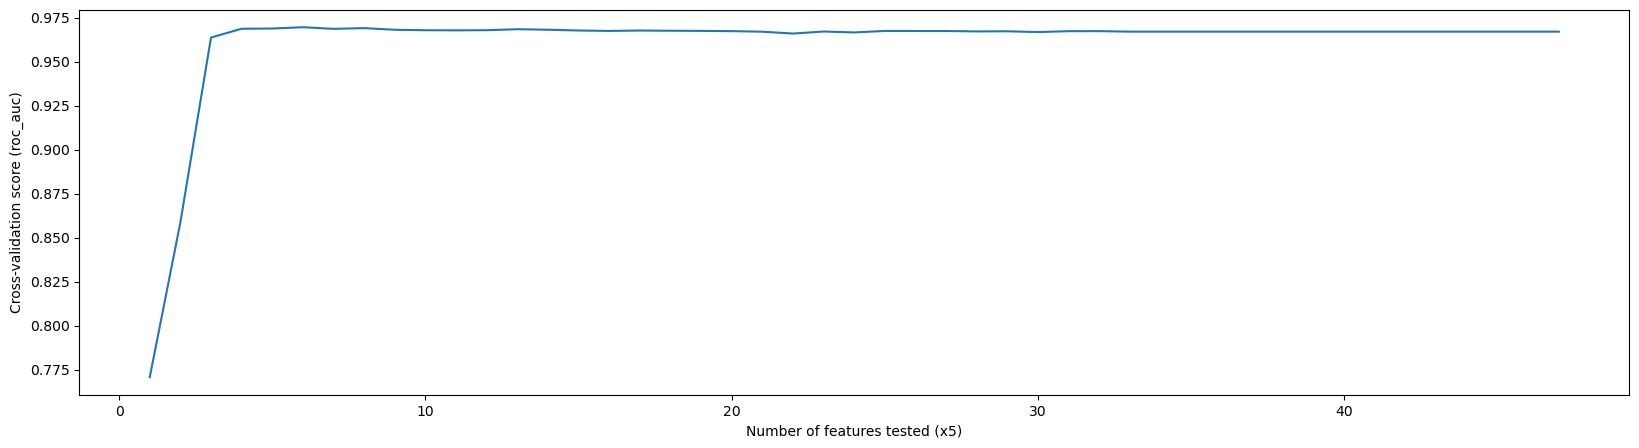

In [107]:
step=5
plt.figure(figsize=(20, 5))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.xlabel('Number of features tested (x%d)' % step)
plt.ylabel('Cross-validation score (roc_auc)')
plt.show()


In [119]:

import shap 

data_test.reset_index(drop=True, inplace=True)



explainer_lgbm = shap.TreeExplainer(lgbm_opt)
shap_value_lgbm = explainer_lgbm.shap_values(data_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [117]:
pip install shap


     ------------------------------------ 447.3/447.3 kB 481.9 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


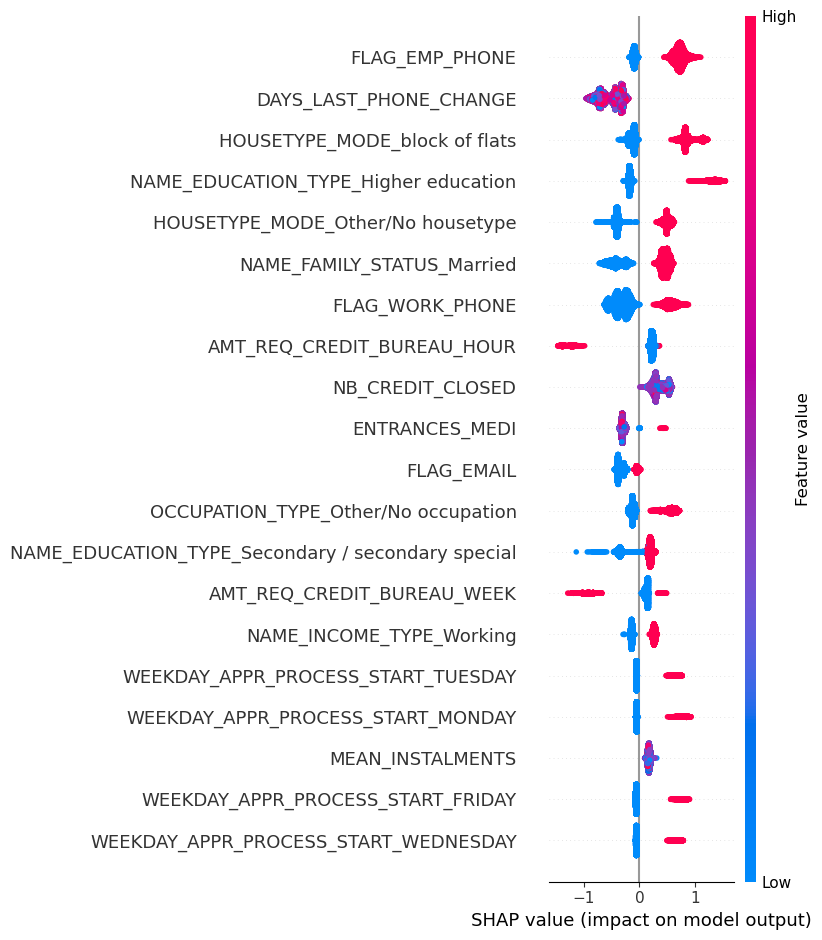

In [120]:

shap.initjs()
shap.summary_plot(shap_value_lgbm[0], data_test)

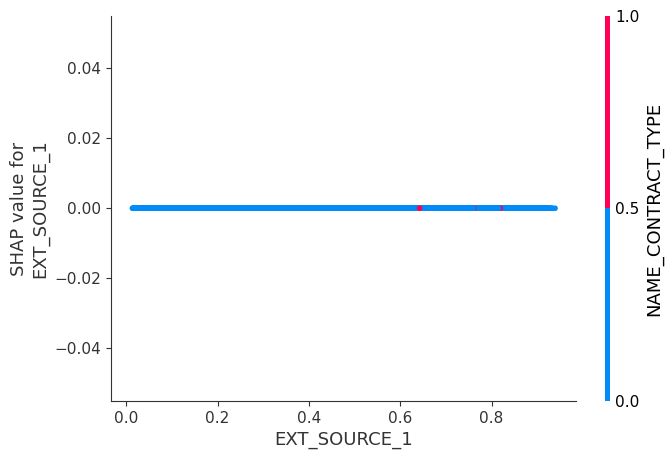

In [121]:
shap.dependence_plot("EXT_SOURCE_1", shap_value_lgbm[0], data_test)